### **一、加载常用库**

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import statsmodels.api as sm
import gc
pd.set_option('display.max_columns', None)

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
import seaborn as sns
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
#函数：对因子数据进行MAD去极值处理(.value_counts())
def filter_extreme_MAD(series,n):
    md = np.median(series)
    mad = np.median((series-md).abs())
    max_range = md + n*mad
    min_range = md - n*mad
    return np.clip(series,min_range,max_range)

### **二、合并所有因子并存入hdf**

alphas135_style = pd.read_hdf('D:/191alphas/alphas135_style.h5', key='alphas135_style')

alphas46_style = pd.read_hdf('D:/191alphas/alphas46_style.h5', key='alphas46_style')

alphas46_style.drop(columns=['Beta','Momentum','Size','EarningsYield','Volatility','Growth','Value','Leverage','Liquidity','return','industry'], inplace=True)

alphasaa_style = pd.merge(alphas135_style,alphas46_style, on = ['code','date'])

del alphas135_style,alphas46_style

alphasaa_style.to_hdf('D:/191alphas/alphasall_style.h5',key = 'alphasall_style')

### **三、因子去极值、标准化、中性化处理**

#### **1、因子去极值：时间序列+横截面**

In [3]:
#读取全部因子数据
alphasall_style = pd.read_hdf('D:/191alphas/alphasall_style.h5', key='alphasall_style')

In [6]:
len(alphasall_style.code.unique())

3774

In [4]:
alphasall_style

,code,date,Beta,Momentum,Size,EarningsYield,Volatility,Growth,Value,Leverage,Liquidity,return,industry,alpha_1,alpha_2,alpha_5,alpha_6,alpha_7,alpha_8,alpha_9,alpha_11,alpha_12,alpha_13,alpha_14,alpha_15,alpha_16,alpha_17,alpha_18,alpha_20,alpha_22,alpha_24,alpha_25,alpha_26,alpha_28,alpha_29,alpha_31,alpha_32,alpha_33,alpha_34,alpha_35,alpha_36,alpha_37,alpha_39,alpha_41,alpha_42,alpha_44,alpha_45,alpha_46,alpha_47,alpha_48,alpha_52,alpha_54,alpha_57,alpha_60,alpha_61,alpha_62,alpha_63,alpha_64,alpha_65,alpha_66,alpha_67,alpha_68,alpha_70,alpha_71,alpha_72,alpha_73,alpha_74,alpha_76,alpha_77,alpha_78,alpha_79,alpha_80,alpha_81,alpha_82,alpha_83,alpha_85,alpha_87,alpha_88,alpha_89,alpha_90,alpha_91,alpha_92,alpha_95,alpha_96,alpha_97,alpha_99,alpha_100,alpha_102,alpha_104,alpha_105,alpha_106,alpha_107,alpha_108,alpha_109,alpha_110,alpha_111,alpha_113,alpha_114,alpha_115,alpha_117,alpha_118,alpha_119,alpha_120,alpha_121,alpha_122,alpha_124,alpha_125,alpha_126,alpha_130,alpha_131,alpha_132,alpha_134,alpha_135,alpha_136,alpha_138,alpha_139,alpha_140,alpha_141,alpha_142,alpha_145,alpha_146,alpha_150,alpha_151,alpha_152,alpha_153,alpha_155,alpha_156,alpha_157,alpha_158,alpha_159,alpha_161,alpha_162,alpha_163,alpha_168,alpha_169,alpha_170,alpha_171,alpha_173,alpha_175,alpha_176,alpha_178,alpha_179,alpha_181,alpha_184,alpha_185,alpha_188,alpha_189,alpha_191,alpha_3,alpha_4,alpha_10,alpha_19,alpha_23,alpha_27,alpha_38,alpha_40,alpha_43,alpha_49,alpha_50,alpha_51,alpha_53,alpha_55,alpha_56,alpha_58,alpha_59,alpha_69,alpha_75,alpha_84,alpha_86,alpha_93,alpha_94,alpha_98,alpha_101,alpha_103,alpha_112,alpha_123,alpha_127,alpha_128,alpha_129,alpha_133,alpha_137,alpha_144,alpha_148,alpha_154,alpha_160,alpha_164,alpha_167,alpha_172,alpha_174,alpha_177,alpha_180,alpha_182,alpha_186,alpha_187
0,1,2012-06-08,0.553191,-0.000330,18.144622,143.800440,0.042350,0.729137,1012.368380,81.473270,4.859730,-0.026298,480101.0,0.423184,0.098065,0.535826,-0.259609,1.006534,0.873515,-1.423682e-09,-7.266618e+07,-0.171810,0.098471,-0.970000,0.002630,-0.744934,1.702430e+00,0.938530,-5.608668,-0.003300,-0.440630,-0.378280,1.218765,29.397850,-2.229766e+06,-4.574742,-0.469067,0.695185,1.047941,-0.216405,0.058741,-0.202665,0.789497,-0.500175,0.138206,3.0,0.003319,1.041758,75.636955,-0.100904,36.530323,-0.254813,9.982029,-8.227894e+07,-0.499474,0.678752,17.157656,-0.511041,1.032861,-3.181521,35.383675,-9.906452e-10,141542624.0,-6.169320,70.853416,-0.510824,0.763030,0.582532,0.051730,-146.260193,26.780735,151.057541,19696826.00,68.323639,-0.051363,160.0,-2.146750,-8.183509,-0.152256,-0.019916,-0.000177,-15.0,106691800.0,18.270531,8280459.50,-0.055206,7125844.000,70.269653,0.522001,0.289024,-1.32,-0.101418,-0.977924,1.173115,58.103977,1.064504e+07,0.580986,0.021424,0.903383,0.0,54.662380,0.419253,1.510006,-0.577809,-0.000853,-0.169814,2.216013,14.950000,1.517434,5.200698e-02,275576672.0,-2.887704e+06,0.972520,0.070390,6.826056,0.299444,0.995813,-0.040436,-0.015791,20.055986,62.102558,594348096.0,-0.507497,-0.008933,15.428437,1.621117e+06,-0.827514,3.868007,0.033761,-5644.140137,0.278333,0.529447,0.805058,-2.254894,-0.015069,0.770837,-0.100664,17.596117,0.290000,-0.333283,-1.045515e+06,0.021465,0.017001,1.006840,0.107816,80.161758,0.272500,-0.603261,-1.110000,1.0,0.247898,-0.061470,40.773613,-91.532082,0.0,42.772129,-59956860.0,0.797927,-0.595855,0.202073,4.0,-176.927307,1.0,8.0,-0.850000,-0.432258,0.115385,123836264.0,1.0,1.550000,-182454048.0,-0.000000,0.0,100.0,-55.769230,0.0,0.0,30.854437,1.620000,-95.0,-1.126400e+01,4.117760e-11,0.0,1.0,0.198289,6.202394e+02,0.460000,34.642544,0.136509,5.0,60.0,0.90,49.056541,0.88
1,1,2012-06-11,0.554001,-0.000330,18.143270,143.994896,0.042265,0.729137,1013.737370,81.582042,4.870956,-0.001350,480101.0,0.660760,-0.506667,0.663375,-0.259609,0.711266,0.854997,-1.457578e-09,-8.358197e+07,-0.014597,0.018146,-0.610000,0.002701,-0.214535,1.407767e+00,0.960390,-6.273764,-0.003806,-0.474504,-0.392410,1.115514,28.319492,-1.665742e+06,-4.2305

<AxesSubplot:>

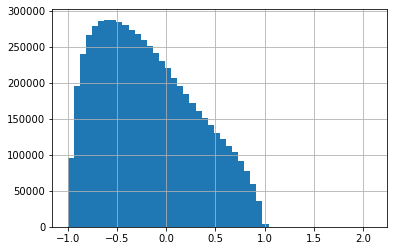

In [14]:
alphasall_style['alpha_1'].hist(bins = 50)

<AxesSubplot:>

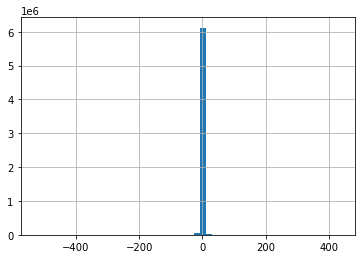

In [16]:
alphasall_style['alpha_3'].hist(bins = 50)

<AxesSubplot:>

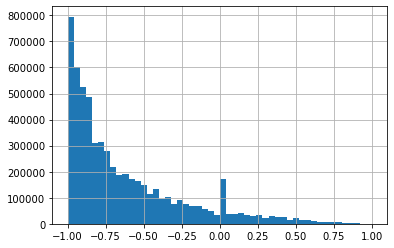

In [20]:
alphasall_style['alpha_5'].hist(bins = 50)

<AxesSubplot:>

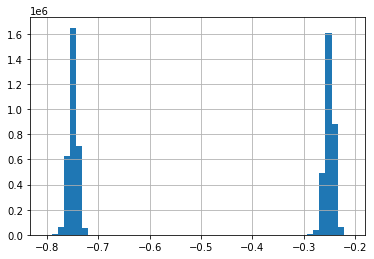

In [23]:
alphasall_style['alpha_6'].hist(bins = 50)

<AxesSubplot:>

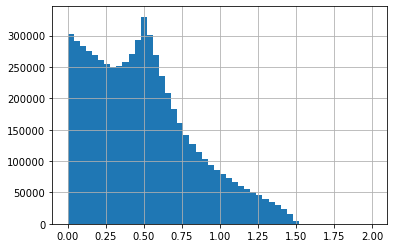

In [87]:
alphasall_style['alpha_7'].hist(bins = 50)

<AxesSubplot:>

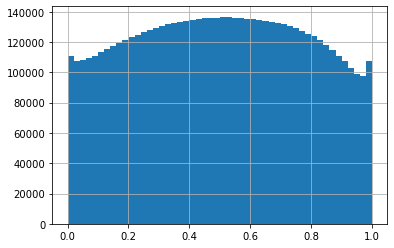

In [88]:
alphasall_style['alpha_8'].hist(bins = 50)

<AxesSubplot:>

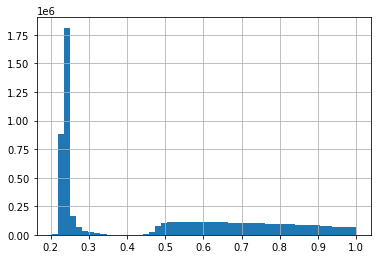

In [90]:
alphasall_style['alpha_10'].hist(bins = 50)

<AxesSubplot:>

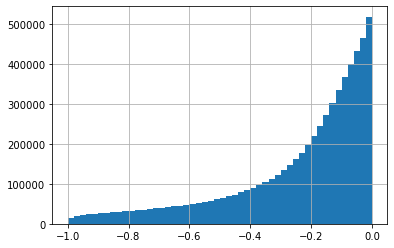

In [58]:
alphasall_style['alpha_12'].hist(bins = 50)

<AxesSubplot:>

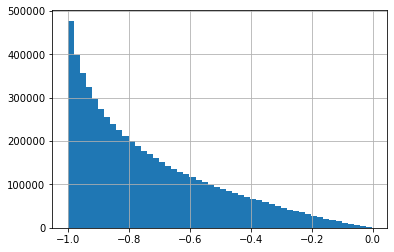

In [67]:
alphasall_style['alpha_16'].hist(bins = 50)

<AxesSubplot:>

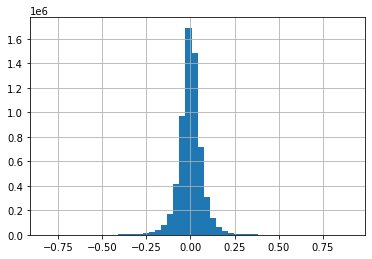

In [70]:
alphasall_style['alpha_19'].hist(bins = 50)

<AxesSubplot:>

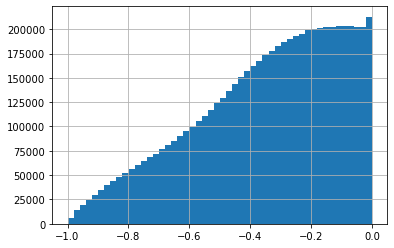

In [86]:
alphasall_style['alpha_35'].hist(bins = 50)

<AxesSubplot:>

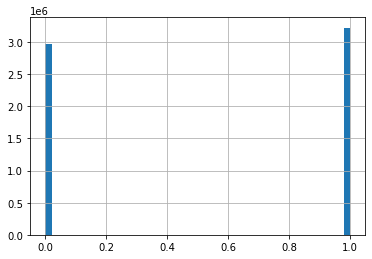

In [45]:
alphasall_style['alpha_56'].hist(bins = 50)

<AxesSubplot:>

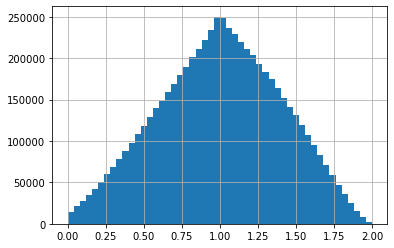

In [44]:
alphasall_style['alpha_184'].hist(bins = 50)

<AxesSubplot:>

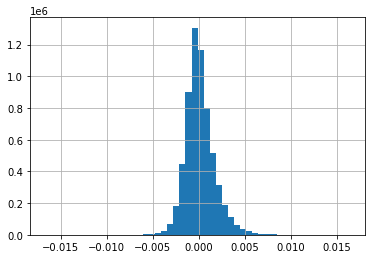

In [95]:
#Beta Momentum Size EarningsYield Volatility Growth Value Leverage Liquidity	
alphasall_style['Momentum'].hist(bins = 50)

<AxesSubplot:>

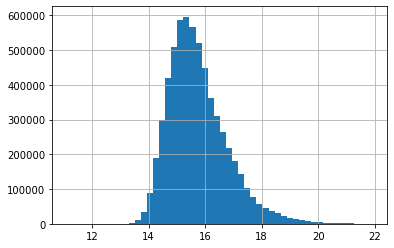

In [96]:
#Beta Momentum Size EarningsYield Volatility Growth Value Leverage Liquidity	
alphasall_style['Size'].hist(bins = 50)

<AxesSubplot:>

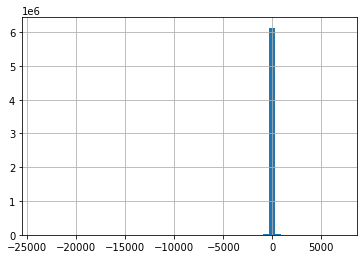

In [97]:
#Beta Momentum Size EarningsYield Volatility Growth Value Leverage Liquidity	
alphasall_style['EarningsYield'].hist(bins = 50)

<AxesSubplot:>

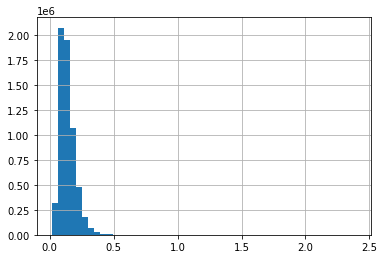

In [98]:
#Beta Momentum Size EarningsYield Volatility Growth Value Leverage Liquidity	
alphasall_style['Volatility'].hist(bins = 50)

<AxesSubplot:>

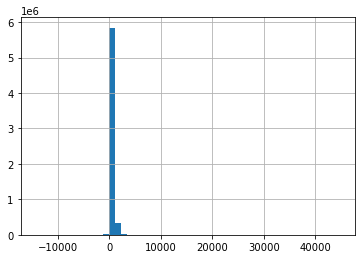

In [100]:
#Beta Momentum Size EarningsYield Volatility Growth Value Leverage Liquidity	
alphasall_style['Value'].hist(bins = 50)

<AxesSubplot:>

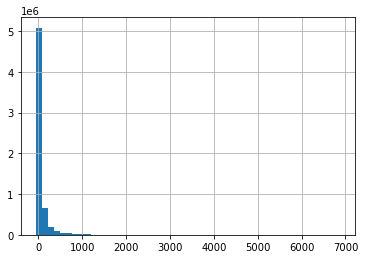

In [101]:
#Beta Momentum Size EarningsYield Volatility Growth Value Leverage Liquidity	
alphasall_style['Leverage'].hist(bins = 50)

<AxesSubplot:>

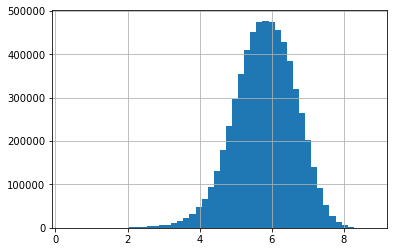

In [102]:
#Beta Momentum Size EarningsYield Volatility Growth Value Leverage Liquidity	
alphasall_style['Liquidity'].hist(bins = 50)

<AxesSubplot:>

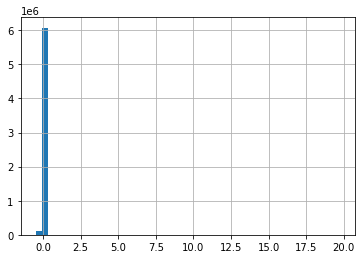

In [103]:
#Beta Momentum Size EarningsYield Volatility Growth Value Leverage Liquidity	
alphasall_style['return'].hist(bins = 50)

In [9]:
#查看每日股票数
alphasall_style['date'].value_counts()[-10:]

2012-03-13    1003
2012-03-12     924
2012-03-09     825
2012-03-08     723
2012-03-07     602
2012-03-06     465
2012-03-05     318
2012-03-02     195
2012-03-01      60
2012-02-29       1
Name: date, dtype: int64

#### **2、因子标准化：横截面**

#### **3、alpha因子中性化,输出resid_1、resid_2、resid_3、resid_4**

##### 3.1 生成行业哑变量，与重置alphasall_style_stan合并并存入hdf

In [4]:
#读取alphasall_style_Standard文件(alphasall_style_stan合并行业dummy)
alphasall_style_Standard = pd.read_hdf('D:/191alphas/alphasall_style_Standard.h5',key = 'alphasall_style_Standard')

In [5]:
alphasall_style_Standard

,code,date,Beta,Momentum,Size,EarningsYield,Volatility,Growth,Value,Leverage,Liquidity,return,industry,alpha_1,alpha_2,alpha_5,alpha_6,alpha_7,alpha_8,alpha_9,alpha_11,alpha_12,alpha_13,alpha_14,alpha_15,alpha_16,alpha_17,alpha_18,alpha_20,alpha_22,alpha_24,alpha_25,alpha_26,alpha_28,alpha_29,alpha_31,alpha_32,alpha_33,alpha_34,alpha_35,alpha_36,alpha_37,alpha_39,alpha_41,alpha_42,alpha_44,alpha_45,alpha_46,alpha_47,alpha_48,alpha_52,alpha_54,alpha_57,alpha_60,alpha_61,alpha_62,alpha_63,alpha_64,alpha_65,alpha_66,alpha_67,alpha_68,alpha_70,alpha_71,alpha_72,alpha_73,alpha_74,alpha_76,alpha_77,alpha_78,alpha_79,alpha_80,alpha_81,alpha_82,alpha_83,alpha_85,alpha_87,alpha_88,alpha_89,alpha_90,alpha_91,alpha_92,alpha_95,alpha_96,alpha_97,alpha_99,alpha_100,alpha_102,alpha_104,alpha_105,alpha_106,alpha_107,alpha_108,alpha_109,alpha_110,alpha_111,alpha_113,alpha_114,alpha_115,alpha_117,alpha_118,alpha_119,alpha_120,alpha_121,alpha_122,alpha_124,alpha_125,alpha_126,alpha_130,alpha_131,alpha_132,alpha_134,alpha_135,alpha_136,alpha_138,alpha_139,alpha_140,alpha_141,alpha_142,alpha_145,alpha_146,alpha_150,alpha_151,alpha_152,alpha_153,alpha_155,alpha_156,alpha_157,alpha_158,alpha_159,alpha_161,alpha_162,alpha_163,alpha_168,alpha_169,alpha_170,alpha_171,alpha_173,alpha_175,alpha_176,alpha_178,alpha_179,alpha_181,alpha_184,alpha_185,alpha_188,alpha_189,alpha_191,alpha_3,alpha_4,alpha_10,alpha_19,alpha_23,alpha_27,alpha_40,alpha_43,alpha_49,alpha_50,alpha_51,alpha_53,alpha_55,alpha_56,alpha_58,alpha_59,alpha_69,alpha_75,alpha_84,alpha_93,alpha_94,alpha_98,alpha_101,alpha_103,alpha_112,alpha_123,alpha_127,alpha_128,alpha_129,alpha_133,alpha_137,alpha_144,alpha_148,alpha_154,alpha_160,alpha_164,alpha_167,alpha_172,alpha_174,alpha_177,alpha_180,alpha_182,alpha_186,alpha_187,110,210,220,230,240,270,280,330,340,350,360,370,410,420,430,450,460,480,490,510,610,620,630,640,650,710,720,730
0,2,2012-03-12,-0.812246,1.490566,2.794474,2.240843,-1.103205,0.359292,0.857649,1.277298,-0.801097,-0.029070,430,0.797185,0.625414,-0.615610,1.183299,1.551010,1.182207,-0.735011,-2.707096,0.727119,2.283374,-0.868094,-1.904728,1.256873,1.736251,-1.069633,-1.322026,-0.852560,-0.236997,0.410626,1.032040,-0.117902,-3.182298,-1.433424,0.828541,-0.536580,1.451998,-0.325498,-0.799097,0.866229,2.153689,-0.528731,1.134993,-1.253438,-0.901742,1.580269,0.759456,1.977650,-0.670930,1.732710,-0.891656,2.376123,-0.802576,1.681425,-1.711746,0.403889,1.834682,-1.812095,-0.309178,-0.713795,3.179271,-0.764821,0.669064,0.956978,-0.167383,1.370826,0.477025,-1.247972,-1.206028,-0.304400,3.256811,0.613156,1.047624,3.205438,0.475547,-0.159381,-0.406019,1.314831,0.694095,0.999077,3.475627,-0.107911,3.012003,1.604226,3.048825,0.319615,0.023898,1.731488,-0.327694,1.842039,-0.098092,0.349690,0.701004,3.455985,0.270796,0.995541,0.378017,-1.595055,0.272123,0.800003,1.832408,0.287359,0.100460,-1.148014,0.521899,-0.379275,2.006762,-1.238940,3.279895,2.625049,0.201457,1.047784,1.205875,1.613000,0.056946,1.307273,0.554834,-0.639220,-2.141217,2.897140,0.089056,-1.141062,-0.352224,-2.416672,0.866266,-0.351286,0.508961,0.183079,-0.291719,-1.800933,1.422325,-0.046984,-0.362138,2.107475,1.070733,-0.338347,-0.378786,-1.765200,-2.969829,-0.797744,-0.152077,0.349136,-1.510753,0.685909,-0.839352,-0.273690,-1.575803,1.0,-0.956789,-1.082496,-1.929769,1.143754,-1.299434,-2.872546,0.089815,-0.089814,-0.089814,-1.333182,0.008217,1.0,-1.612943,-0.781263,0.162316,-0.716360,2.772871,-0.339502,2.106060,0.423056,0.0,-0.571427,-0.535591,0.0,-0.980739,0.003617,-0.036483,0.439417,-2.282972,-1.201768,-1.0,1.0,-0.439676,-0.655480,-0.316451,0.807375,-0.833870,0.136189,0.819076,-0.135137,0.452510,-0.354037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,2012-03-12,-0.240366,0.763640,0.050347,2.240843,-0.196264,0.059493,0.406627,1.277298,-0.490862,-0.014599,430,0.337958,1.297309,0.071120,1.183299,0.953266,2.245469,-0.601403,-1.040962,-0.893866,0.289369,-0.622204,0.694021,-0.445301,0.642848,-0.838126,-0.022742,-

<AxesSubplot:>

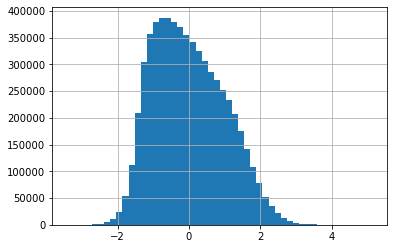

In [9]:
alphasall_style_Standard['alpha_1'].hist(bins = 50)

<AxesSubplot:>

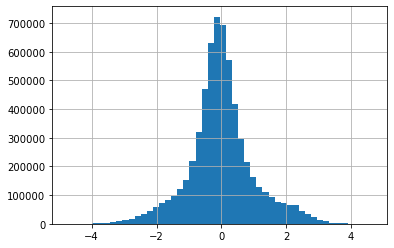

In [7]:
alphasall_style_Standard['alpha_3'].hist(bins = 50)

<AxesSubplot:>

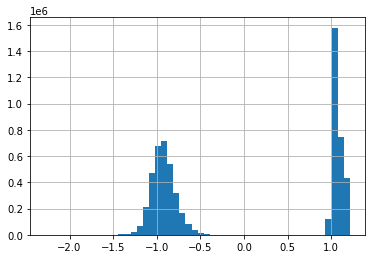

In [10]:
alphasall_style_Standard['alpha_6'].hist(bins = 50)

<AxesSubplot:>

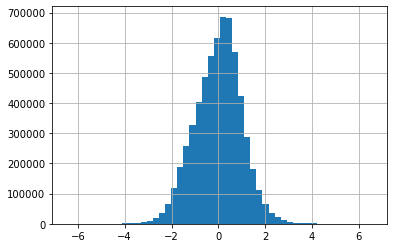

In [11]:
alphasall_style_Standard['alpha_8'].hist(bins = 50)

<AxesSubplot:>

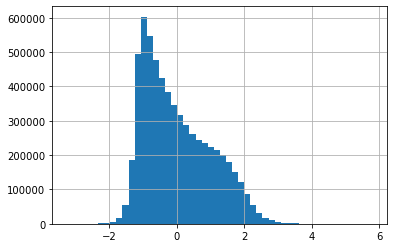

In [12]:
alphasall_style_Standard['alpha_16'].hist(bins = 50)

<AxesSubplot:>

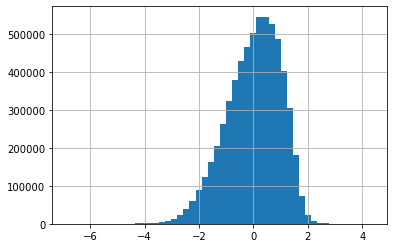

In [13]:
alphasall_style_Standard['alpha_35'].hist(bins = 50)

<AxesSubplot:>

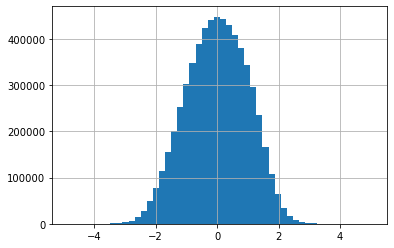

In [15]:
alphasall_style_Standard['alpha_184'].hist(bins = 50)

<AxesSubplot:>

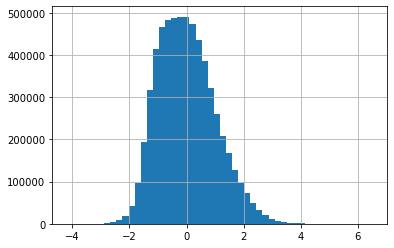

In [17]:
alphasall_style_Standard['alpha_7'].hist(bins = 50)

<AxesSubplot:>

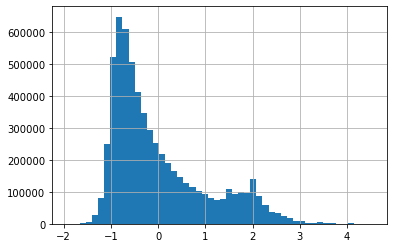

In [31]:
alphasall_style_Standard['alpha_100'].hist(bins = 50)

<AxesSubplot:>

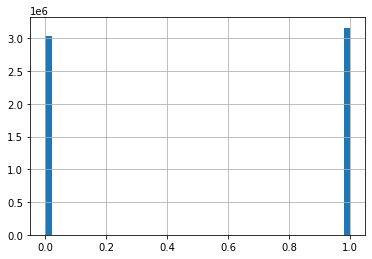

In [32]:
alphasall_style_Standard['alpha_101'].hist(bins = 50)

<AxesSubplot:>

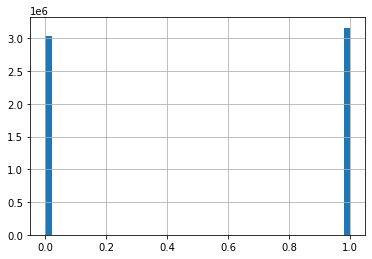

In [32]:
alphasall_style_Standard['alpha_101'].hist(bins = 50)

<AxesSubplot:>

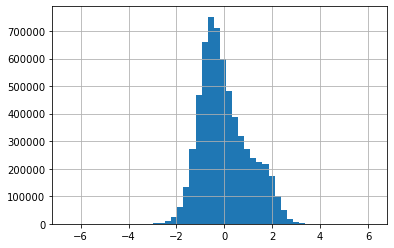

In [33]:
alphasall_style_Standard['alpha_102'].hist(bins = 50)

<AxesSubplot:>

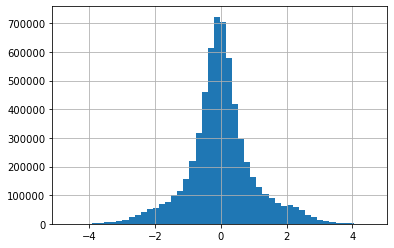

In [34]:
alphasall_style_Standard['alpha_106'].hist(bins = 50)

<AxesSubplot:>

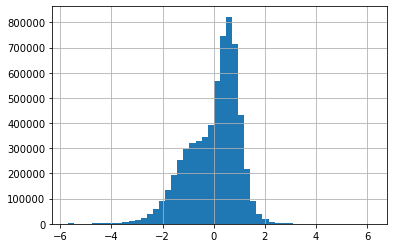

In [35]:
alphasall_style_Standard['alpha_107'].hist(bins = 50)

<AxesSubplot:>

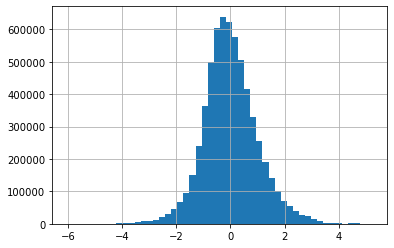

In [18]:
#Beta	Momentum	Size	EarningsYield	Volatility	Growth	Value	Leverage	Liquidity	
alphasall_style_Standard['Beta'].hist(bins = 50)

<AxesSubplot:>

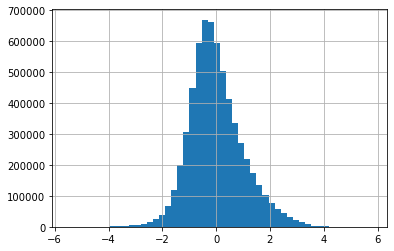

In [19]:
#Beta	Momentum	Size	EarningsYield	Volatility	Growth	Value	Leverage	Liquidity	
alphasall_style_Standard['Momentum'].hist(bins = 50)

<AxesSubplot:>

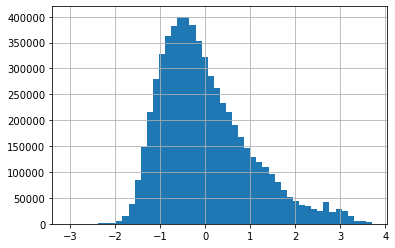

In [25]:
#Beta	Momentum	Size	EarningsYield	Volatility	Growth	Value	Leverage	Liquidity	
alphasall_style_Standard['Size'].hist(bins = 50)

<AxesSubplot:>

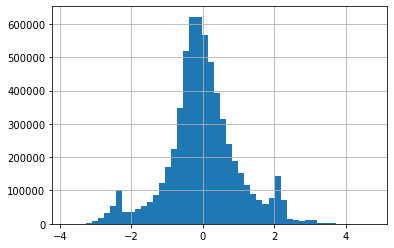

In [21]:
#Beta	Momentum	Size	EarningsYield	Volatility	Growth	Value	Leverage	Liquidity	
alphasall_style_Standard['EarningsYield'].hist(bins = 50)

<AxesSubplot:>

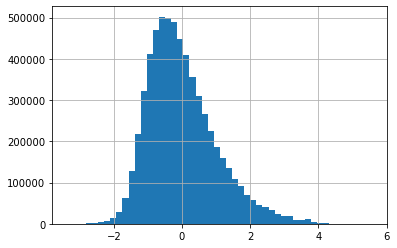

In [22]:
#Beta	Momentum	Size	EarningsYield	Volatility	Growth	Value	Leverage	Liquidity	
alphasall_style_Standard['Volatility'].hist(bins = 50)

<AxesSubplot:>

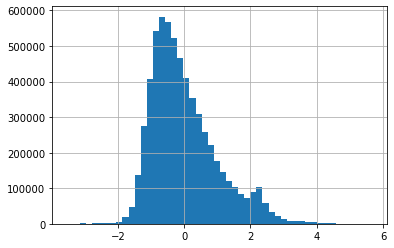

In [24]:
#Beta	Momentum	Size	EarningsYield	Volatility	Growth	Value	Leverage	Liquidity	
alphasall_style_Standard['Value'].hist(bins = 50)

<AxesSubplot:>

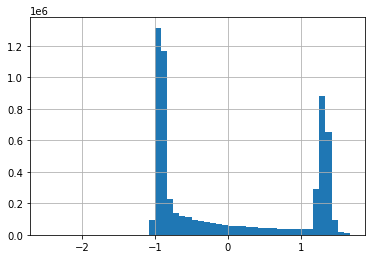

In [28]:
#Beta	Momentum	Size	EarningsYield	Volatility	Growth	Value	Leverage	Liquidity	
alphasall_style_Standard['Leverage'].hist(bins = 50)

<AxesSubplot:>

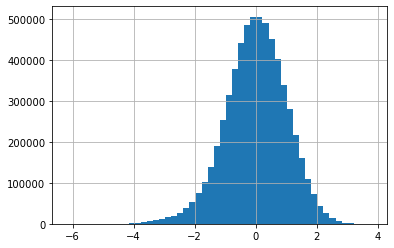

In [27]:
#Beta	Momentum	Size	EarningsYield	Volatility	Growth	Value	Leverage	Liquidity	
alphasall_style_Standard['Liquidity'].hist(bins = 50)

In [ ]:
#提取因子列表
factorlist = alphasall_style_Standard.columns.to_list()
#剔除不需要被回归的列，包括行业哑变量与九个风格因子
removelist = ['code','date','return','industry','Beta','Momentum','Size','EarningsYield','Volatility','Growth','Value','Leverage','Liquidity','110','210','220','230','240','270','280','330','340','350','360','370','410','420','430','450','460','480','490','510','610','620','630','640','650','710','720','730']
for i in removelist:
    factorlist.remove(i)

In [ ]:
#还有179个因子
len(factorlist)

In [ ]:
#将factorlist均分成四组，以便回归
factorlist1 = factorlist[:45]
factorlist2 = factorlist[45:90]
factorlist3 = factorlist[90:135]
factorlist4 = factorlist[135:]

In [ ]:
#X = alphasall_style_stan[['Beta','Momentum','Size','EarningsYield','Volatility','Growth','Value','Leverage','Liquidity','110','210','220','230','240','270','280','330','340','350','360','370','410','420','430','450','460','480','490','510','610','620','630','640','650','710','720','730']]
#Y = alphasall_style_stan['alpha']
#因子中性化函数：最小二乘法回归获得残差，自变量为行业哑变量和九类风格因子
def OLS_resid(data,factor):
    X = data[['Beta','Momentum','Size','EarningsYield','Volatility','Growth','Value','Leverage','Liquidity','110','210','220','230','240','270','280','330','340','350','360','370','410','420','430','450','460','480','490','510','610','620','630','640','650','710','720','730']]
    Y = data.loc[:,factor]
    result = sm.OLS(Y,X).fit()
    return result.resid

#alpha横截面回归
def get_resid(factorlist):
    residlist = []
    for alpha in factorlist:
        locals()[str(alpha)+'_resid'] = alphasall_style_Standard.groupby('date').apply(lambda x: OLS_resid(x,factor = alpha))#str(alpha)+'resid'命名残差的dataframe
        residlist.append(str(alpha)+'_resid')#生成df名称列表
        
    resid_all = pd.DataFrame()
    for resid in residlist:
        resid_all = pd.concat([resid_all, locals()[resid]], axis=1)#输出resid_all
    resid_all.columns = residlist
    resid_all.reset_index(inplace = True)
    
    return resid_all

##### 3.1回归第一组：resid_1

In [ ]:
#耗时1h
resid_1 = get_resid(factorlist1)

In [ ]:
resid_1.to_hdf('D:/191alphas/resid.h5',key = 'resid_1')

##### 3.2回归第2组：输出resid_2

In [ ]:
resid_2 = get_resid(factorlist2)

In [ ]:
resid_2.to_hdf('D:/191alphas/resid.h5',key = 'resid_2')

##### 3.3回归第3组：输出resid_3

In [ ]:
resid_3 = get_resid(factorlist3)

In [ ]:
resid_3.to_hdf('D:/191alphas/resid.h5',key = 'resid_3')

##### 3.4回归第3组：输出resid_4

In [ ]:
resid_4 = get_resid(factorlist4)

In [ ]:
resid_4.to_hdf('D:/191alphas/resid.h5',key = 'resid_4')

### **四、单因子检验**

In [6]:
#需要变号的因子列表
change_sig_list = ["alpha_10_resid","alpha_100_resid","alpha_101_resid","alpha_102_resid","alpha_106_resid","alpha_107_resid","alpha_109_resid",
                   "alpha_11_resid","alpha_110_resid","alpha_112_resid","alpha_115_resid","alpha_117_resid","alpha_118_resid","alpha_119_resid",
                   "alpha_122_resid","alpha_124_resid","alpha_125_resid","alpha_126_resid","alpha_128_resid","alpha_129_resid","alpha_13_resid",
                   "alpha_132_resid","alpha_133_resid","alpha_134_resid","alpha_135_resid","alpha_14_resid","alpha_142_resid","alpha_145_resid",
                   "alpha_146_resid","alpha_150_resid","alpha_151_resid","alpha_152_resid","alpha_153_resid","alpha_154_resid","alpha_155_resid",
                   "alpha_158_resid","alpha_159_resid","alpha_161_resid","alpha_162_resid","alpha_167_resid","alpha_169_resid","alpha_170_resid",
                   "alpha_172_resid","alpha_173_resid","alpha_175_resid","alpha_176_resid","alpha_177_resid","alpha_179_resid","alpha_18_resid",
                   "alpha_180_resid","alpha_186_resid","alpha_187_resid","alpha_188_resid","alpha_189_resid","alpha_19_resid","alpha_191_resid",
                   "alpha_2_resid","alpha_20_resid","alpha_22_resid","alpha_23_resid","alpha_24_resid","alpha_27_resid","alpha_29_resid",
                   "alpha_3_resid","alpha_31_resid","alpha_36_resid","alpha_40_resid","alpha_43_resid","alpha_44_resid","alpha_45_resid",
                   "alpha_50_resid","alpha_51_resid","alpha_52_resid","alpha_53_resid","alpha_55_resid","alpha_56_resid","alpha_57_resid",
                   "alpha_58_resid","alpha_59_resid","alpha_60_resid","alpha_63_resid","alpha_66_resid","alpha_67_resid","alpha_68_resid",
                   "alpha_69_resid","alpha_7_resid","alpha_70_resid","alpha_71_resid","alpha_74_resid","alpha_75_resid","alpha_76_resid",
                   "alpha_77_resid","alpha_79_resid","alpha_80_resid","alpha_81_resid","alpha_84_resid","alpha_85_resid","alpha_88_resid",
                   "alpha_89_resid","alpha_9_resid","alpha_94_resid","alpha_95_resid","alpha_96_resid","alpha_97_resid","alpha_98_resid"]

#变号函数
def resid_change_sig(resid_n):
    changelist = list(set(resid_n.columns).intersection(set(change_sig_list)))
    for i in changelist:
        resid_n.loc[:,i] = resid_n.loc[:,i]*(-1)
    return resid_n

In [4]:
#读取风格因子
style = pd.read_hdf('D:/191alphas/style.h5', key = 'style')

In [26]:
#读取回归残差值resid_1，resid_2，resid_3，resid_4
resid_1 = pd.read_hdf('D:/191alphas/resid.h5', key = 'resid_1')
resid_2 = pd.read_hdf('D:/191alphas/resid.h5', key = 'resid_2')
resid_3 = pd.read_hdf('D:/191alphas/resid.h5', key = 'resid_3')
resid_4 = pd.read_hdf('D:/191alphas/resid.h5', key = 'resid_4')

In [27]:
#因子残差变号
resid_1 = resid_change_sig(resid_1)

In [28]:
resid_2 = resid_change_sig(resid_2)

In [29]:
resid_3 = resid_change_sig(resid_3)

In [30]:
resid_4 = resid_change_sig(resid_4)

In [5]:
#读取回归残差值resid,为resid_1，resid_2，resid_3，resid_4合并，转换数据类型之后的值
resid = pd.read_hdf('D:/191alphas/resid.h5', key = 'resid_float32')

<AxesSubplot:>

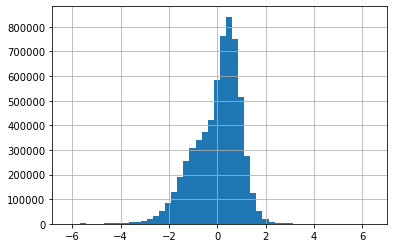

In [11]:
resid['alpha_107_resid'].hist(bins = 50)

<AxesSubplot:>

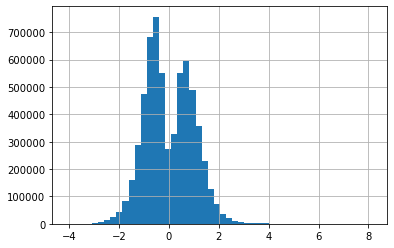

In [12]:
resid['alpha_10_resid'].hist(bins = 50)

<AxesSubplot:>

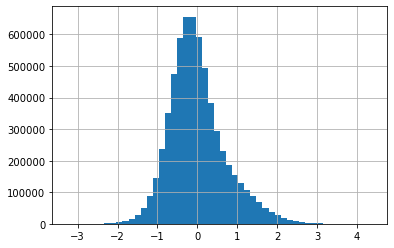

In [13]:
resid['alpha_100_resid'].hist(bins = 50)

In [7]:
#因子残差变号
resid = resid_change_sig(resid)

In [8]:
resid

,alpha_1_resid,alpha_2_resid,alpha_5_resid,alpha_6_resid,alpha_7_resid,alpha_8_resid,alpha_9_resid,alpha_11_resid,alpha_12_resid,alpha_13_resid,alpha_14_resid,alpha_15_resid,alpha_16_resid,alpha_17_resid,alpha_18_resid,alpha_20_resid,alpha_22_resid,alpha_24_resid,alpha_25_resid,alpha_26_resid,alpha_28_resid,alpha_29_resid,alpha_31_resid,alpha_32_resid,alpha_33_resid,alpha_34_resid,alpha_35_resid,alpha_36_resid,alpha_37_resid,alpha_39_resid,alpha_41_resid,alpha_42_resid,alpha_44_resid,alpha_45_resid,alpha_46_resid,alpha_47_resid,alpha_48_resid,alpha_52_resid,alpha_54_resid,alpha_57_resid,alpha_60_resid,alpha_61_resid,alpha_62_resid,alpha_63_resid,alpha_64_resid,alpha_65_resid,alpha_66_resid,alpha_67_resid,alpha_68_resid,alpha_70_resid,alpha_71_resid,alpha_72_resid,alpha_73_resid,alpha_74_resid,alpha_76_resid,alpha_77_resid,alpha_78_resid,alpha_79_resid,alpha_80_resid,alpha_81_resid,alpha_82_resid,alpha_83_resid,alpha_85_resid,alpha_87_resid,alpha_88_resid,alpha_89_resid,alpha_90_resid,alpha_91_resid,alpha_92_resid,alpha_95_resid,alpha_96_resid,alpha_97_resid,alpha_99_resid,alpha_100_resid,alpha_102_resid,alpha_104_resid,alpha_105_resid,alpha_106_resid,alpha_107_resid,alpha_108_resid,alpha_109_resid,alpha_110_resid,alpha_111_resid,alpha_113_resid,alpha_114_resid,alpha_115_resid,alpha_117_resid,alpha_118_resid,alpha_119_resid,alpha_120_resid,alpha_121_resid,alpha_122_resid,alpha_124_resid,alpha_125_resid,alpha_126_resid,alpha_130_resid,alpha_131_resid,alpha_132_resid,alpha_134_resid,alpha_135_resid,alpha_136_resid,alpha_138_resid,alpha_139_resid,alpha_140_resid,alpha_141_resid,alpha_142_resid,alpha_145_resid,alpha_146_resid,alpha_150_resid,alpha_151_resid,alpha_152_resid,alpha_153_resid,alpha_155_resid,alpha_156_resid,alpha_157_resid,alpha_158_resid,alpha_159_resid,alpha_161_resid,alpha_162_resid,alpha_163_resid,alpha_168_resid,alpha_169_resid,alpha_170_resid,alpha_171_resid,alpha_173_resid,alpha_175_resid,alpha_176_resid,alpha_178_resid,alpha_179_resid,alpha_181_resid,alpha_184_resid,alpha_185_resid,alpha_188_resid,alpha_189_resid,alpha_191_resid,alpha_3_resid,alpha_4_resid,alpha_10_resid,alpha_19_resid,alpha_23_resid,alpha_27_resid,alpha_40_resid,alpha_43_resid,alpha_49_resid,alpha_50_resid,alpha_51_resid,alpha_53_resid,alpha_55_resid,alpha_56_resid,alpha_58_resid,alpha_59_resid,alpha_69_resid,alpha_75_resid,alpha_84_resid,alpha_93_resid,alpha_94_resid,alpha_98_resid,alpha_101_resid,alpha_103_resid,alpha_112_resid,alpha_123_resid,alpha_127_resid,alpha_128_resid,alpha_129_resid,alpha_133_resid,alpha_137_resid,alpha_144_resid,alpha_148_resid,alpha_154_resid,alpha_160_resid,alpha_164_resid,alpha_167_resid,alpha_172_resid,alpha_174_resid,alpha_177_resid,alpha_180_resid,alpha_182_resid,alpha_186_resid,alpha_187_resid
0,-0.140041,0.009211,-0.818990,0.379502,-1.169235,-0.068671,-0.048082,1.455688,0.602879,-1.761898,0.112082,-1.602739,0.693576,0.836605,-0.168210,-0.055764,-0.407376,-0.173384,0.228813,0.391821,0.122017,1.910613,0.149739,0.611717,-0.604694,0.161551,-0.129771,0.501387,-0.542437,1.381745,-0.313333,0.861617,0.074403,0.631917,0.374147,-0.113753,0.745712,0.014781,0.778233,-0.200737,-1.904871,-0.753583,1.219929,0.230137,0.454452,0.399797,0.383250,-0.009776,0.192598,-1.571160,0.118874,-0.106754,0.538113,0.017125,-1.316845,-0.857139,0.207088,0.050911,-0.081660,-1.162755,-0.080194,0.656933,-2.058905,0.229781,-0.106385,-0.034183,0.952547,-0.268408,0.618770,-1.446425,-0.370525,-1.349403,0.909890,-1.008466,-0.546535,-0.205998,0.960317,0.285456,-1.601388,0.869972,-0.302072,-0.610042,2.946412,0.031926,0.656566,-0.718726,0.310225,-0.486610,-1.514992,1.626140,0.818743,-0.077401,0.733955,-0.291685,0.715960,1.473051,-0.969759,-1.259281,-2.123979,0.001131,0.363061,1.342543,0.895067,-0.164796,0.883326,0.506841,0.606890,1.298886,-1.058514,0.319570,0.112568,0.727329,1.098819,0.301395,-0.385141,-0.078627,-0.211728,0.835623,0.291709,0.135986,-0.330275,0.240157,-0.863783,0.262776,0.694849,0.779264,1.156327,-1.660255,0.502059,-0.014806,-0.321292,

<AxesSubplot:>

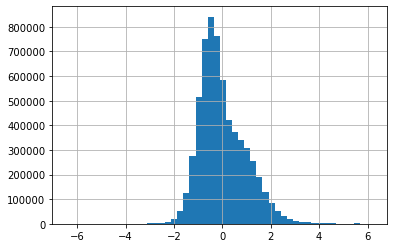

In [9]:
resid['alpha_107_resid'].hist(bins = 50)

<AxesSubplot:>

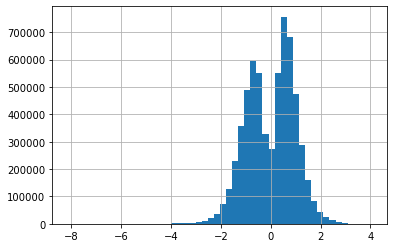

In [18]:
resid['alpha_10_resid'].hist(bins = 50)

<AxesSubplot:>

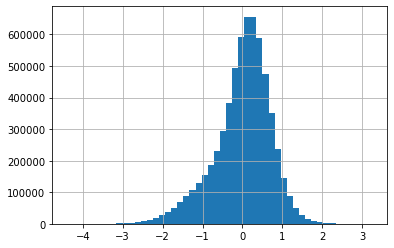

In [19]:
resid['alpha_100_resid'].hist(bins = 50)

#### **1、ICIR检验**

In [ ]:
#因子残差与次日股票收益率的IC
def get_IC(resid,style,column):
    
    alphas_test = pd.concat([style,resid],axis=1) #合并style与resid
    alphas_test.drop(columns = ['level_0','level_1'], inplace=True)
    alphas_test.sort_values(by = ['code','date'], inplace=True)
    alphas_test.reset_index(drop = True, inplace=True)
    alphas_test.loc[:,'return_1'] = alphas_test.groupby('code')[column].shift(-1)#求return的一阶前置项
    alphas_test.dropna(inplace=True)
    
    residlist = resid.columns.to_list()[2:]#提取残差名列表
    IC = pd.DataFrame()
    for i in residlist:
        IC.loc[:,'IC_'+str(i)] = alphas_test.groupby(['date']).apply(lambda x: x[i].corr(x['return_1'],method='spearman'))#求IC
    
    return IC

In [4]:
IC = pd.read_hdf('D:/191alphas/IC.h5',key = 'IC')

In [5]:
IC.loc[:,'year'] = IC.index.year

In [6]:
IC_mean = IC.groupby('year').mean()

In [7]:
IC_mean.loc[:,'mean'] = IC_mean.mean(axis = 1)

In [8]:
IC_mean

,IC_alpha_1_resid,IC_alpha_2_resid,IC_alpha_5_resid,IC_alpha_6_resid,IC_alpha_7_resid,IC_alpha_8_resid,IC_alpha_9_resid,IC_alpha_11_resid,IC_alpha_12_resid,IC_alpha_13_resid,IC_alpha_14_resid,IC_alpha_15_resid,IC_alpha_16_resid,IC_alpha_17_resid,IC_alpha_18_resid,IC_alpha_20_resid,IC_alpha_22_resid,IC_alpha_24_resid,IC_alpha_25_resid,IC_alpha_26_resid,IC_alpha_28_resid,IC_alpha_29_resid,IC_alpha_31_resid,IC_alpha_32_resid,IC_alpha_33_resid,IC_alpha_34_resid,IC_alpha_35_resid,IC_alpha_36_resid,IC_alpha_37_resid,IC_alpha_39_resid,IC_alpha_41_resid,IC_alpha_42_resid,IC_alpha_44_resid,IC_alpha_45_resid,IC_alpha_46_resid,IC_alpha_47_resid,IC_alpha_48_resid,IC_alpha_52_resid,IC_alpha_54_resid,IC_alpha_57_resid,IC_alpha_60_resid,IC_alpha_61_resid,IC_alpha_62_resid,IC_alpha_63_resid,IC_alpha_64_resid,IC_alpha_65_resid,IC_alpha_66_resid,IC_alpha_67_resid,IC_alpha_68_resid,IC_alpha_70_resid,IC_alpha_71_resid,IC_alpha_72_resid,IC_alpha_73_resid,IC_alpha_74_resid,IC_alpha_76_resid,IC_alpha_77_resid,IC_alpha_78_resid,IC_alpha_79_resid,IC_alpha_80_resid,IC_alpha_81_resid,IC_alpha_82_resid,IC_alpha_83_resid,IC_alpha_85_resid,IC_alpha_87_resid,IC_alpha_88_resid,IC_alpha_89_resid,IC_alpha_90_resid,IC_alpha_91_resid,IC_alpha_92_resid,IC_alpha_95_resid,IC_alpha_96_resid,IC_alpha_97_resid,IC_alpha_99_resid,IC_alpha_100_resid,IC_alpha_102_resid,IC_alpha_104_resid,IC_alpha_105_resid,IC_alpha_106_resid,IC_alpha_107_resid,IC_alpha_108_resid,IC_alpha_109_resid,IC_alpha_110_resid,IC_alpha_111_resid,IC_alpha_113_resid,IC_alpha_114_resid,IC_alpha_115_resid,IC_alpha_117_resid,IC_alpha_118_resid,IC_alpha_119_resid,IC_alpha_120_resid,IC_alpha_121_resid,IC_alpha_122_resid,IC_alpha_124_resid,IC_alpha_125_resid,IC_alpha_126_resid,IC_alpha_130_resid,IC_alpha_131_resid,IC_alpha_132_resid,IC_alpha_134_resid,IC_alpha_135_resid,IC_alpha_136_resid,IC_alpha_138_resid,IC_alpha_139_resid,IC_alpha_140_resid,IC_alpha_141_resid,IC_alpha_142_resid,IC_alpha_145_resid,IC_alpha_146_resid,IC_alpha_150_resid,IC_alpha_151_resid,IC_alpha_152_resid,IC_alpha_153_resid,IC_alpha_155_resid,IC_alpha_156_resid,IC_alpha_157_resid,IC_alpha_158_resid,IC_alpha_159_resid,IC_alpha_161_resid,IC_alpha_162_resid,IC_alpha_163_resid,IC_alpha_168_resid,IC_alpha_169_resid,IC_alpha_170_resid,IC_alpha_171_resid,IC_alpha_173_resid,IC_alpha_175_resid,IC_alpha_176_resid,IC_alpha_178_resid,IC_alpha_179_resid,IC_alpha_181_resid,IC_alpha_184_resid,IC_alpha_185_resid,IC_alpha_188_resid,IC_alpha_189_resid,IC_alpha_191_resid,IC_alpha_3_resid,IC_alpha_4_resid,IC_alpha_10_resid,IC_alpha_19_resid,IC_alpha_23_resid,IC_alpha_27_resid,IC_alpha_40_resid,IC_alpha_43_resid,IC_alpha_49_resid,IC_alpha_50_resid,IC_alpha_51_resid,IC_alpha_53_resid,IC_alpha_55_resid,IC_alpha_56_resid,IC_alpha_58_resid,IC_alpha_59_resid,IC_alpha_69_resid,IC_alpha_75_resid,IC_alpha_84_resid,IC_alpha_93_resid,IC_alpha_94_resid,IC_alpha_98_resid,IC_alpha_101_resid,IC_alpha_103_resid,IC_alpha_112_resid,IC_alpha_123_resid,IC_alpha_127_resid,IC_alpha_128_resid,IC_alpha_129_resid,IC_alpha_133_resid,IC_alpha_137_resid,IC_alpha_144_resid,IC_alpha_148_resid,IC_alpha_154_resid,IC_alpha_160_resid,IC_alpha_164_resid,IC_alpha_167_resid,IC_alpha_172_resid,IC_alpha_174_resid,IC_alpha_177_resid,IC_alpha_180_resid,IC_alpha_182_resid,IC_alpha_186_resid,IC_alpha_187_resid,mean
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012,0.037790,0.007582,0.027779,-0.003356,0.008930,0.049892,0.048089,0.051296,0.060092,0.015332,0.056146,0.018325,0.030820,0.051344,0.067340,0.067325,0.052273,0.045069,0.048909,0.052941,-0.008845,0.047229,0.065463,0.027261,0.019267,0.065357,0.032639,0.026421,0.043045,0.037384,0.008374,0.024275,0.031856,0.026606,0.064456,0.042932,0.060374,0.030272,0.015696,0.055047,0.030980,0.033026,0.022116,0.062695,0.002687,0.060955,0.060877,0.044538,0.040720,0.028790,0.054034,0.033530,0.009595,0.023640,0.014117,-0.010135,

全部区间的IC值

In [9]:
IC_des = IC.describe()

In [10]:
IC_des.loc['ICIR',:] = IC_des.loc['mean',:]/IC_des.loc['std',:]

In [11]:
keeplist = ['IC_alpha_15_resid','IC_alpha_120_resid','IC_alpha_80_resid','IC_alpha_32_resid','IC_alpha_16_resid','IC_alpha_42_resid',
            'IC_alpha_13_resid','IC_alpha_124_resid','IC_alpha_102_resid','IC_alpha_5_resid','IC_alpha_168_resid','IC_alpha_11_resid',
            'IC_alpha_36_resid','IC_alpha_114_resid','IC_alpha_12_resid','IC_alpha_74_resid','IC_alpha_140_resid','IC_alpha_179_resid',
            'IC_alpha_108_resid','IC_alpha_9_resid','IC_alpha_68_resid','IC_alpha_90_resid','IC_alpha_139_resid','IC_alpha_109_resid',
            'IC_alpha_62_resid','IC_alpha_1_resid','IC_alpha_107_resid','IC_alpha_145_resid','IC_alpha_176_resid','IC_alpha_60_resid',
            'IC_alpha_188_resid','IC_alpha_91_resid','IC_alpha_105_resid','IC_alpha_158_resid','IC_alpha_121_resid','IC_alpha_75_resid',
            'IC_alpha_163_resid','IC_alpha_99_resid','IC_alpha_171_resid','IC_alpha_48_resid','IC_alpha_3_resid','IC_alpha_83_resid',
            'IC_alpha_100_resid','IC_alpha_4_resid','IC_alpha_156_resid','IC_alpha_73_resid','IC_alpha_55_resid','IC_alpha_97_resid',
            'IC_alpha_43_resid','IC_alpha_150_resid','IC_alpha_95_resid','IC_alpha_35_resid','IC_alpha_155_resid','IC_alpha_180_resid',
            'IC_alpha_41_resid','IC_alpha_136_resid','IC_alpha_24_resid','IC_alpha_70_resid','IC_alpha_141_resid','IC_alpha_40_resid',
            'IC_alpha_182_resid','IC_alpha_77_resid','IC_alpha_128_resid','IC_alpha_104_resid','IC_alpha_191_resid','IC_alpha_118_resid',
            'IC_alpha_33_resid','IC_alpha_117_resid','IC_alpha_14_resid','IC_alpha_130_resid','IC_alpha_122_resid','IC_alpha_185_resid',
            'IC_alpha_72_resid','IC_alpha_82_resid','IC_alpha_47_resid','IC_alpha_81_resid','IC_alpha_69_resid','IC_alpha_17_resid',
            'IC_alpha_94_resid','IC_alpha_184_resid','IC_alpha_84_resid','IC_alpha_135_resid','IC_alpha_113_resid','IC_alpha_87_resid',
            'IC_alpha_59_resid','IC_alpha_61_resid','IC_alpha_29_resid','IC_alpha_159_resid','IC_alpha_151_resid','IC_alpha_177_resid',
            'IC_alpha_111_resid','IC_alpha_96_resid','IC_alpha_101_resid','IC_alpha_54_resid','IC_alpha_152_resid','IC_alpha_52_resid',
            'IC_alpha_169_resid','IC_alpha_27_resid','IC_alpha_58_resid','IC_alpha_53_resid','IC_alpha_92_resid','IC_alpha_20_resid',
            'IC_alpha_89_resid','IC_alpha_18_resid','IC_alpha_106_resid','IC_alpha_19_resid','IC_alpha_57_resid','IC_alpha_25_resid',
            'IC_alpha_88_resid','IC_alpha_133_resid','IC_alpha_71_resid','IC_alpha_23_resid','IC_alpha_67_resid','IC_alpha_50_resid',
            'IC_alpha_51_resid','IC_alpha_49_resid','IC_alpha_26_resid','IC_alpha_39_resid','IC_alpha_79_resid','IC_alpha_31_resid',
            'IC_alpha_34_resid','IC_alpha_123_resid','IC_alpha_46_resid']

In [12]:
IC_des_head123 = IC_des[keeplist]

In [13]:
IC_des_head123

,IC_alpha_15_resid,IC_alpha_120_resid,IC_alpha_80_resid,IC_alpha_32_resid,IC_alpha_16_resid,IC_alpha_42_resid,IC_alpha_13_resid,IC_alpha_124_resid,IC_alpha_102_resid,IC_alpha_5_resid,IC_alpha_168_resid,IC_alpha_11_resid,IC_alpha_36_resid,IC_alpha_114_resid,IC_alpha_12_resid,IC_alpha_74_resid,IC_alpha_140_resid,IC_alpha_179_resid,IC_alpha_108_resid,IC_alpha_9_resid,IC_alpha_68_resid,IC_alpha_90_resid,IC_alpha_139_resid,IC_alpha_109_resid,IC_alpha_62_resid,IC_alpha_1_resid,IC_alpha_107_resid,IC_alpha_145_resid,IC_alpha_176_resid,IC_alpha_60_resid,IC_alpha_188_resid,IC_alpha_91_resid,IC_alpha_105_resid,IC_alpha_158_resid,IC_alpha_121_resid,IC_alpha_75_resid,IC_alpha_163_resid,IC_alpha_99_resid,IC_alpha_171_resid,IC_alpha_48_resid,IC_alpha_3_resid,IC_alpha_83_resid,IC_alpha_100_resid,IC_alpha_4_resid,IC_alpha_156_resid,IC_alpha_73_resid,IC_alpha_55_resid,IC_alpha_97_resid,IC_alpha_43_resid,IC_alpha_150_resid,IC_alpha_95_resid,IC_alpha_35_resid,IC_alpha_155_resid,IC_alpha_180_resid,IC_alpha_41_resid,IC_alpha_136_resid,IC_alpha_24_resid,IC_alpha_70_resid,IC_alpha_141_resid,IC_alpha_40_resid,IC_alpha_182_resid,IC_alpha_77_resid,IC_alpha_128_resid,IC_alpha_104_resid,IC_alpha_191_resid,IC_alpha_118_resid,IC_alpha_33_resid,IC_alpha_117_resid,IC_alpha_14_resid,IC_alpha_130_resid,IC_alpha_122_resid,IC_alpha_185_resid,IC_alpha_72_resid,IC_alpha_82_resid,IC_alpha_47_resid,IC_alpha_81_resid,IC_alpha_69_resid,IC_alpha_17_resid,IC_alpha_94_resid,IC_alpha_184_resid,IC_alpha_84_resid,IC_alpha_135_resid,IC_alpha_113_resid,IC_alpha_87_resid,IC_alpha_59_resid,IC_alpha_61_resid,IC_alpha_29_resid,IC_alpha_159_resid,IC_alpha_151_resid,IC_alpha_177_resid,IC_alpha_111_resid,IC_alpha_96_resid,IC_alpha_101_resid,IC_alpha_54_resid,IC_alpha_152_resid,IC_alpha_52_resid,IC_alpha_169_resid,IC_alpha_27_resid,IC_alpha_58_resid,IC_alpha_53_resid,IC_alpha_92_resid,IC_alpha_20_resid,IC_alpha_89_resid,IC_alpha_18_resid,IC_alpha_106_resid,IC_alpha_19_resid,IC_alpha_57_resid,IC_alpha_25_resid,IC_alpha_88_resid,IC_alpha_133_resid,IC_alpha_71_resid,IC_alpha_23_resid,IC_alpha_67_resid,IC_alpha_50_resid,IC_alpha_51_resid,IC_alpha_49_resid,IC_alpha_26_resid,IC_alpha_39_resid,IC_alpha_79_resid,IC_alpha_31_resid,IC_alpha_34_resid,IC_alpha_123_resid,IC_alpha_46_resid
count,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000
mean,0.021979,0.053099,0.047315,0.027045,0.028668,0.034067,0.010866,0.055080,0.053046,0.024436,0.054383,0.044356,0.027006,0.051934,0.044924,0.024405,0.062928,0.024652,0.010479,0.044251,0.040130,0.025164,0.012457,0.049248,0.023180,0.035182,0.003396,0.035783,0.0

In [14]:
IC_des.loc['mean',:].mean()

11.226553747485342

In [15]:
IC_des.loc['ICIR',:].mean()

4.250619959397347

In [15]:
IC_des_head123.loc['mean',:].mean()

0.03053922390903671

In [16]:
IC_des_head123.loc['ICIR',:].mean()

0.4412058075409551

<AxesSubplot:>

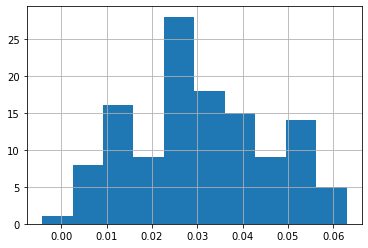

In [21]:
IC_des_head123.loc['mean',:].hist()

<AxesSubplot:>

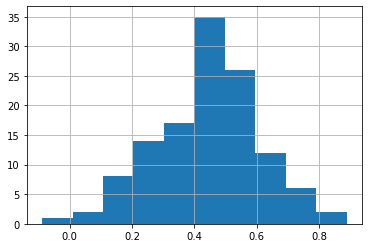

In [18]:
IC_des_head123.loc['ICIR',:].hist()

12-16的IC值

In [6]:
IC12_17 = IC.loc['2012-03-12':'2016-12-31',:]

In [19]:
IC12_17_des = IC12_17.describe()

In [20]:
IC12_17_des.loc['ICIR',:] = IC12_17_des.loc['mean',:]/IC12_17_des.loc['std',:]

In [22]:
IC12_17_des.loc['mean',:].mean()

0.02688860574390404

In [23]:
IC12_17_des.loc['ICIR',:].mean()

0.36467160267852794

17-22的IC值

In [64]:
IC17_22 = IC.loc['2017-01-01':'2022-01-27',:]

In [65]:
IC17_22_des = IC17_22.describe()

In [66]:
IC17_22_des.loc['ICIR',:] = IC17_22_des.loc['mean',:]/IC17_22_des.loc['std',:]

In [68]:
IC17_22_des.loc['mean',:].mean()

0.019699197971537793

In [69]:
IC17_22_des.loc['ICIR',:].mean()

0.30357939916919463

#### **1附：用股指期货对冲风格和行业因子的收益率**

In [42]:
#读取股指期货数据
Future = pd.read_csv('D:/191alphas/FFUT_FDT/FFUT_FDT.csv')

In [43]:
Future.sort_values(by = ['Trddt','Agmtcd'], inplace=True)

In [44]:
Future.loc[:,'F_return'] = Future['Updown2']/Future['Ystprc']

In [45]:
Future = Future[Future['Trdvar'] == '沪深300指数期货']

In [46]:
Future_first = Future.groupby('Trddt').first()

In [47]:
Future_first.drop(columns=['Agmtcd','Trdvar','Stprc','Ystprc','Updown2'],inplace=True)

In [48]:
Future_first.reset_index(inplace=True)

In [49]:
Future_first.columns = ['date','F_return']

In [50]:
Future_first['date'] = pd.to_datetime(Future_first['date'])

In [43]:
style = style.merge(Future_first, on = 'date', how='left')

In [44]:
style.loc[:,'return_hedge'] = style['return'] - style['F_return']

In [45]:
IC_hedge_1 = get_IC(resid_1,style,column='return_hedge')#约350s

In [46]:
IC_hedge_2 = get_IC(resid_2,style,column='return_hedge')

In [47]:
IC_hedge_3 = get_IC(resid_3,style,column='return_hedge')

In [48]:
IC_hedge_4 = get_IC(resid_4,style,column='return_hedge')

In [49]:
IC_hedge = pd.concat([IC_hedge_1, IC_hedge_2, IC_hedge_3, IC_hedge_4], axis=1)

In [50]:
IC_hedge

,IC_alpha_1_resid,IC_alpha_2_resid,IC_alpha_5_resid,IC_alpha_6_resid,IC_alpha_7_resid,IC_alpha_8_resid,IC_alpha_9_resid,IC_alpha_11_resid,IC_alpha_12_resid,IC_alpha_13_resid,IC_alpha_14_resid,IC_alpha_15_resid,IC_alpha_16_resid,IC_alpha_17_resid,IC_alpha_18_resid,IC_alpha_20_resid,IC_alpha_22_resid,IC_alpha_24_resid,IC_alpha_25_resid,IC_alpha_26_resid,IC_alpha_28_resid,IC_alpha_29_resid,IC_alpha_31_resid,IC_alpha_32_resid,IC_alpha_33_resid,IC_alpha_34_resid,IC_alpha_35_resid,IC_alpha_36_resid,IC_alpha_37_resid,IC_alpha_39_resid,IC_alpha_41_resid,IC_alpha_42_resid,IC_alpha_44_resid,IC_alpha_45_resid,IC_alpha_46_resid,IC_alpha_47_resid,IC_alpha_48_resid,IC_alpha_52_resid,IC_alpha_54_resid,IC_alpha_57_resid,IC_alpha_60_resid,IC_alpha_61_resid,IC_alpha_62_resid,IC_alpha_63_resid,IC_alpha_64_resid,IC_alpha_65_resid,IC_alpha_66_resid,IC_alpha_67_resid,IC_alpha_68_resid,IC_alpha_70_resid,IC_alpha_71_resid,IC_alpha_72_resid,IC_alpha_73_resid,IC_alpha_74_resid,IC_alpha_76_resid,IC_alpha_77_resid,IC_alpha_78_resid,IC_alpha_79_resid,IC_alpha_80_resid,IC_alpha_81_resid,IC_alpha_82_resid,IC_alpha_83_resid,IC_alpha_85_resid,IC_alpha_87_resid,IC_alpha_88_resid,IC_alpha_89_resid,IC_alpha_90_resid,IC_alpha_91_resid,IC_alpha_92_resid,IC_alpha_95_resid,IC_alpha_96_resid,IC_alpha_97_resid,IC_alpha_99_resid,IC_alpha_100_resid,IC_alpha_102_resid,IC_alpha_104_resid,IC_alpha_105_resid,IC_alpha_106_resid,IC_alpha_107_resid,IC_alpha_108_resid,IC_alpha_109_resid,IC_alpha_110_resid,IC_alpha_111_resid,IC_alpha_113_resid,IC_alpha_114_resid,IC_alpha_115_resid,IC_alpha_117_resid,IC_alpha_118_resid,IC_alpha_119_resid,IC_alpha_120_resid,IC_alpha_121_resid,IC_alpha_122_resid,IC_alpha_124_resid,IC_alpha_125_resid,IC_alpha_126_resid,IC_alpha_130_resid,IC_alpha_131_resid,IC_alpha_132_resid,IC_alpha_134_resid,IC_alpha_135_resid,IC_alpha_136_resid,IC_alpha_138_resid,IC_alpha_139_resid,IC_alpha_140_resid,IC_alpha_141_resid,IC_alpha_142_resid,IC_alpha_145_resid,IC_alpha_146_resid,IC_alpha_150_resid,IC_alpha_151_resid,IC_alpha_152_resid,IC_alpha_153_resid,IC_alpha_155_resid,IC_alpha_156_resid,IC_alpha_157_resid,IC_alpha_158_resid,IC_alpha_159_resid,IC_alpha_161_resid,IC_alpha_162_resid,IC_alpha_163_resid,IC_alpha_168_resid,IC_alpha_169_resid,IC_alpha_170_resid,IC_alpha_171_resid,IC_alpha_173_resid,IC_alpha_175_resid,IC_alpha_176_resid,IC_alpha_178_resid,IC_alpha_179_resid,IC_alpha_181_resid,IC_alpha_184_resid,IC_alpha_185_resid,IC_alpha_188_resid,IC_alpha_189_resid,IC_alpha_191_resid,IC_alpha_3_resid,IC_alpha_4_resid,IC_alpha_10_resid,IC_alpha_19_resid,IC_alpha_23_resid,IC_alpha_27_resid,IC_alpha_40_resid,IC_alpha_43_resid,IC_alpha_49_resid,IC_alpha_50_resid,IC_alpha_51_resid,IC_alpha_53_resid,IC_alpha_55_resid,IC_alpha_56_resid,IC_alpha_58_resid,IC_alpha_59_resid,IC_alpha_69_resid,IC_alpha_75_resid,IC_alpha_84_resid,IC_alpha_93_resid,IC_alpha_94_resid,IC_alpha_98_resid,IC_alpha_101_resid,IC_alpha_103_resid,IC_alpha_112_resid,IC_alpha_123_resid,IC_alpha_127_resid,IC_alpha_128_resid,IC_alpha_129_resid,IC_alpha_133_resid,IC_alpha_137_resid,IC_alpha_144_resid,IC_alpha_148_resid,IC_alpha_154_resid,IC_alpha_160_resid,IC_alpha_164_resid,IC_alpha_167_resid,IC_alpha_172_resid,IC_alpha_174_resid,IC_alpha_177_resid,IC_alpha_180_resid,IC_alpha_182_resid,IC_alpha_186_resid,IC_alpha_187_resid
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-03-12,0.081799,-0.121720,0.080212,0.049300,-0.086216,0.032583,0.049541,0.122751,0.105575,-0.024728,0.134230,0.042415,0.120767,0.151533,0.177498,0.212456,0.056034,0.216801,0.115596,0.103430,-0.020167,0.160029,0.237433,0.061664,0.122295,0.235384,0.067792,0.028901,0.129194,0.066919,0.052896,0.083545,0.108723,0.118576,0.259057,0.173669,0.099911,0.211297,0.198387,0.168069,0.129976,0.181247,0.029852,0.229196,-0.001490,0.139141,0.140697,0.269923,0.101098,0.089464,0.279378,0.178734,-0.014223,0.085983,-0.019610,-0.03

In [62]:
IC_hedge.to_hdf('D:/191alphas/IC.h5',key = 'IC_hedge')

In [3]:
IC_hedge = pd.read_hdf('D:/191alphas/IC.h5',key = 'IC_hedge')

In [4]:
IC_hedge_des = IC_hedge.describe()

In [5]:
IC_hedge_des

,IC_alpha_1_resid,IC_alpha_2_resid,IC_alpha_5_resid,IC_alpha_6_resid,IC_alpha_7_resid,IC_alpha_8_resid,IC_alpha_9_resid,IC_alpha_11_resid,IC_alpha_12_resid,IC_alpha_13_resid,IC_alpha_14_resid,IC_alpha_15_resid,IC_alpha_16_resid,IC_alpha_17_resid,IC_alpha_18_resid,IC_alpha_20_resid,IC_alpha_22_resid,IC_alpha_24_resid,IC_alpha_25_resid,IC_alpha_26_resid,IC_alpha_28_resid,IC_alpha_29_resid,IC_alpha_31_resid,IC_alpha_32_resid,IC_alpha_33_resid,IC_alpha_34_resid,IC_alpha_35_resid,IC_alpha_36_resid,IC_alpha_37_resid,IC_alpha_39_resid,IC_alpha_41_resid,IC_alpha_42_resid,IC_alpha_44_resid,IC_alpha_45_resid,IC_alpha_46_resid,IC_alpha_47_resid,IC_alpha_48_resid,IC_alpha_52_resid,IC_alpha_54_resid,IC_alpha_57_resid,IC_alpha_60_resid,IC_alpha_61_resid,IC_alpha_62_resid,IC_alpha_63_resid,IC_alpha_64_resid,IC_alpha_65_resid,IC_alpha_66_resid,IC_alpha_67_resid,IC_alpha_68_resid,IC_alpha_70_resid,IC_alpha_71_resid,IC_alpha_72_resid,IC_alpha_73_resid,IC_alpha_74_resid,IC_alpha_76_resid,IC_alpha_77_resid,IC_alpha_78_resid,IC_alpha_79_resid,IC_alpha_80_resid,IC_alpha_81_resid,IC_alpha_82_resid,IC_alpha_83_resid,IC_alpha_85_resid,IC_alpha_87_resid,IC_alpha_88_resid,IC_alpha_89_resid,IC_alpha_90_resid,IC_alpha_91_resid,IC_alpha_92_resid,IC_alpha_95_resid,IC_alpha_96_resid,IC_alpha_97_resid,IC_alpha_99_resid,IC_alpha_100_resid,IC_alpha_102_resid,IC_alpha_104_resid,IC_alpha_105_resid,IC_alpha_106_resid,IC_alpha_107_resid,IC_alpha_108_resid,IC_alpha_109_resid,IC_alpha_110_resid,IC_alpha_111_resid,IC_alpha_113_resid,IC_alpha_114_resid,IC_alpha_115_resid,IC_alpha_117_resid,IC_alpha_118_resid,IC_alpha_119_resid,IC_alpha_120_resid,IC_alpha_121_resid,IC_alpha_122_resid,IC_alpha_124_resid,IC_alpha_125_resid,IC_alpha_126_resid,IC_alpha_130_resid,IC_alpha_131_resid,IC_alpha_132_resid,IC_alpha_134_resid,IC_alpha_135_resid,IC_alpha_136_resid,IC_alpha_138_resid,IC_alpha_139_resid,IC_alpha_140_resid,IC_alpha_141_resid,IC_alpha_142_resid,IC_alpha_145_resid,IC_alpha_146_resid,IC_alpha_150_resid,IC_alpha_151_resid,IC_alpha_152_resid,IC_alpha_153_resid,IC_alpha_155_resid,IC_alpha_156_resid,IC_alpha_157_resid,IC_alpha_158_resid,IC_alpha_159_resid,IC_alpha_161_resid,IC_alpha_162_resid,IC_alpha_163_resid,IC_alpha_168_resid,IC_alpha_169_resid,IC_alpha_170_resid,IC_alpha_171_resid,IC_alpha_173_resid,IC_alpha_175_resid,IC_alpha_176_resid,IC_alpha_178_resid,IC_alpha_179_resid,IC_alpha_181_resid,IC_alpha_184_resid,IC_alpha_185_resid,IC_alpha_188_resid,IC_alpha_189_resid,IC_alpha_191_resid,IC_alpha_3_resid,IC_alpha_4_resid,IC_alpha_10_resid,IC_alpha_19_resid,IC_alpha_23_resid,IC_alpha_27_resid,IC_alpha_40_resid,IC_alpha_43_resid,IC_alpha_49_resid,IC_alpha_50_resid,IC_alpha_51_resid,IC_alpha_53_resid,IC_alpha_55_resid,IC_alpha_56_resid,IC_alpha_58_resid,IC_alpha_59_resid,IC_alpha_69_resid,IC_alpha_75_resid,IC_alpha_84_resid,IC_alpha_93_resid,IC_alpha_94_resid,IC_alpha_98_resid,IC_alpha_101_resid,IC_alpha_103_resid,IC_alpha_112_resid,IC_alpha_123_resid,IC_alpha_127_resid,IC_alpha_128_resid,IC_alpha_129_resid,IC_alpha_133_resid,IC_alpha_137_resid,IC_alpha_144_resid,IC_alpha_148_resid,IC_alpha_154_resid,IC_alpha_160_resid,IC_alpha_164_resid,IC_alpha_167_resid,IC_alpha_172_resid,IC_alpha_174_resid,IC_alpha_177_resid,IC_alpha_180_resid,IC_alpha_182_resid,IC_alpha_186_resid,IC_alpha_187_resid
count,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,

In [6]:
keeplist = ['IC_alpha_15_resid','IC_alpha_120_resid','IC_alpha_80_resid','IC_alpha_32_resid','IC_alpha_16_resid','IC_alpha_42_resid',
            'IC_alpha_13_resid','IC_alpha_124_resid','IC_alpha_102_resid','IC_alpha_5_resid','IC_alpha_168_resid','IC_alpha_11_resid',
            'IC_alpha_36_resid','IC_alpha_114_resid','IC_alpha_12_resid','IC_alpha_74_resid','IC_alpha_140_resid','IC_alpha_179_resid',
            'IC_alpha_108_resid','IC_alpha_9_resid','IC_alpha_68_resid','IC_alpha_90_resid','IC_alpha_139_resid','IC_alpha_109_resid',
            'IC_alpha_62_resid','IC_alpha_1_resid','IC_alpha_107_resid','IC_alpha_145_resid','IC_alpha_176_resid','IC_alpha_60_resid',
            'IC_alpha_188_resid','IC_alpha_91_resid','IC_alpha_105_resid','IC_alpha_158_resid','IC_alpha_121_resid','IC_alpha_75_resid',
            'IC_alpha_163_resid','IC_alpha_99_resid','IC_alpha_171_resid','IC_alpha_48_resid','IC_alpha_3_resid','IC_alpha_83_resid',
            'IC_alpha_100_resid','IC_alpha_4_resid','IC_alpha_156_resid','IC_alpha_73_resid','IC_alpha_55_resid','IC_alpha_97_resid',
            'IC_alpha_43_resid','IC_alpha_150_resid','IC_alpha_95_resid','IC_alpha_35_resid','IC_alpha_155_resid','IC_alpha_180_resid',
            'IC_alpha_41_resid','IC_alpha_136_resid','IC_alpha_24_resid','IC_alpha_70_resid','IC_alpha_141_resid','IC_alpha_40_resid',
            'IC_alpha_182_resid','IC_alpha_77_resid','IC_alpha_128_resid','IC_alpha_104_resid','IC_alpha_191_resid','IC_alpha_118_resid',
            'IC_alpha_33_resid','IC_alpha_117_resid','IC_alpha_14_resid','IC_alpha_130_resid','IC_alpha_122_resid','IC_alpha_185_resid',
            'IC_alpha_72_resid','IC_alpha_82_resid','IC_alpha_47_resid','IC_alpha_81_resid','IC_alpha_69_resid','IC_alpha_17_resid',
            'IC_alpha_94_resid','IC_alpha_184_resid','IC_alpha_84_resid','IC_alpha_135_resid','IC_alpha_113_resid','IC_alpha_87_resid',
            'IC_alpha_59_resid','IC_alpha_61_resid','IC_alpha_29_resid','IC_alpha_159_resid','IC_alpha_151_resid','IC_alpha_177_resid',
            'IC_alpha_111_resid','IC_alpha_96_resid','IC_alpha_101_resid','IC_alpha_54_resid','IC_alpha_152_resid','IC_alpha_52_resid',
            'IC_alpha_169_resid','IC_alpha_27_resid','IC_alpha_58_resid','IC_alpha_53_resid','IC_alpha_92_resid','IC_alpha_20_resid',
            'IC_alpha_89_resid','IC_alpha_18_resid','IC_alpha_106_resid','IC_alpha_19_resid','IC_alpha_57_resid','IC_alpha_25_resid',
            'IC_alpha_88_resid','IC_alpha_133_resid','IC_alpha_71_resid','IC_alpha_23_resid','IC_alpha_67_resid','IC_alpha_50_resid',
            'IC_alpha_51_resid','IC_alpha_49_resid','IC_alpha_26_resid','IC_alpha_39_resid','IC_alpha_79_resid','IC_alpha_31_resid',
            'IC_alpha_34_resid','IC_alpha_123_resid','IC_alpha_46_resid']

In [7]:
IC_hedge_des_head123 = IC_hedge_des[keeplist].copy()

In [8]:
IC_hedge_des_head123

,IC_alpha_15_resid,IC_alpha_120_resid,IC_alpha_80_resid,IC_alpha_32_resid,IC_alpha_16_resid,IC_alpha_42_resid,IC_alpha_13_resid,IC_alpha_124_resid,IC_alpha_102_resid,IC_alpha_5_resid,IC_alpha_168_resid,IC_alpha_11_resid,IC_alpha_36_resid,IC_alpha_114_resid,IC_alpha_12_resid,IC_alpha_74_resid,IC_alpha_140_resid,IC_alpha_179_resid,IC_alpha_108_resid,IC_alpha_9_resid,IC_alpha_68_resid,IC_alpha_90_resid,IC_alpha_139_resid,IC_alpha_109_resid,IC_alpha_62_resid,IC_alpha_1_resid,IC_alpha_107_resid,IC_alpha_145_resid,IC_alpha_176_resid,IC_alpha_60_resid,IC_alpha_188_resid,IC_alpha_91_resid,IC_alpha_105_resid,IC_alpha_158_resid,IC_alpha_121_resid,IC_alpha_75_resid,IC_alpha_163_resid,IC_alpha_99_resid,IC_alpha_171_resid,IC_alpha_48_resid,IC_alpha_3_resid,IC_alpha_83_resid,IC_alpha_100_resid,IC_alpha_4_resid,IC_alpha_156_resid,IC_alpha_73_resid,IC_alpha_55_resid,IC_alpha_97_resid,IC_alpha_43_resid,IC_alpha_150_resid,IC_alpha_95_resid,IC_alpha_35_resid,IC_alpha_155_resid,IC_alpha_180_resid,IC_alpha_41_resid,IC_alpha_136_resid,IC_alpha_24_resid,IC_alpha_70_resid,IC_alpha_141_resid,IC_alpha_40_resid,IC_alpha_182_resid,IC_alpha_77_resid,IC_alpha_128_resid,IC_alpha_104_resid,IC_alpha_191_resid,IC_alpha_118_resid,IC_alpha_33_resid,IC_alpha_117_resid,IC_alpha_14_resid,IC_alpha_130_resid,IC_alpha_122_resid,IC_alpha_185_resid,IC_alpha_72_resid,IC_alpha_82_resid,IC_alpha_47_resid,IC_alpha_81_resid,IC_alpha_69_resid,IC_alpha_17_resid,IC_alpha_94_resid,IC_alpha_184_resid,IC_alpha_84_resid,IC_alpha_135_resid,IC_alpha_113_resid,IC_alpha_87_resid,IC_alpha_59_resid,IC_alpha_61_resid,IC_alpha_29_resid,IC_alpha_159_resid,IC_alpha_151_resid,IC_alpha_177_resid,IC_alpha_111_resid,IC_alpha_96_resid,IC_alpha_101_resid,IC_alpha_54_resid,IC_alpha_152_resid,IC_alpha_52_resid,IC_alpha_169_resid,IC_alpha_27_resid,IC_alpha_58_resid,IC_alpha_53_resid,IC_alpha_92_resid,IC_alpha_20_resid,IC_alpha_89_resid,IC_alpha_18_resid,IC_alpha_106_resid,IC_alpha_19_resid,IC_alpha_57_resid,IC_alpha_25_resid,IC_alpha_88_resid,IC_alpha_133_resid,IC_alpha_71_resid,IC_alpha_23_resid,IC_alpha_67_resid,IC_alpha_50_resid,IC_alpha_51_resid,IC_alpha_49_resid,IC_alpha_26_resid,IC_alpha_39_resid,IC_alpha_79_resid,IC_alpha_31_resid,IC_alpha_34_resid,IC_alpha_123_resid,IC_alpha_46_resid
count,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000
mean,0.021980,0.053106,0.047344,0.027036,0.028671,0.034075,0.010873,0.055091,0.053075,0.024440,0.054414,0.044324,0.026996,0.051938,0.044910,0.024395,0.062950,0.024639,0.010483,0.044231,0.040108,0.025156,0.012455,0.049290,0.023165,0.035221,0.003413,0.035829,0.0

In [9]:
IC_hedge_des.loc['ICIR',:] = IC_hedge_des.loc['mean',:]/IC_hedge_des.loc['std',:]

In [10]:
IC_hedge_des_head123.loc['ICIR',:] = IC_hedge_des_head123.loc['mean',:]/IC_hedge_des_head123.loc['std',:]

In [11]:
IC_hedge_des.loc['mean',:].mean() 

0.023204260671273257

In [12]:
IC_hedge_des_head123.loc['mean',:].mean() 

0.030547079473868144

In [13]:
IC_hedge_des.loc['ICIR',:].mean() 

0.3324543611136359

In [14]:
IC_hedge_des_head123.loc['ICIR',:].mean() 

0.441500082361369

<AxesSubplot:>

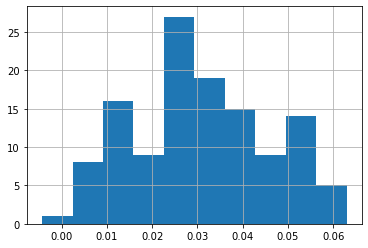

In [15]:
IC_hedge_des_head123.loc['mean',:].hist()

<AxesSubplot:>

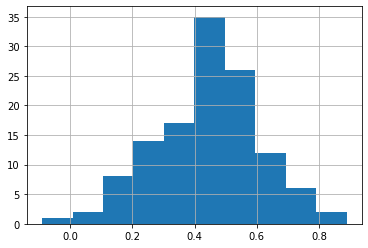

In [16]:
IC_hedge_des_head123.loc['ICIR',:].hist()

用期权对冲后的股票收益率与因子残差的IC值和ICIR相较于未对冲之前提高不多，因此可以怀疑alpha因子可能还是基本面因子

#### **2、多空组合检验**

In [ ]:
#分组收益单因子测试函数：高、低组合分别滚动收益
def group_test(style,resid_n):
    alphas_test = pd.concat([style[['code','date','return']], resid_n],axis=1)#合并数据
    alphas_test.loc[:,'return_1'] = alphas_test.groupby('code')['return'].shift(-1)#求return的一阶前置项
    alphas_test.dropna(inplace=True)#删除空值行
    
    residlist = resid_n.columns[2:]
    groupR_all = pd.DataFrame()
    for resid in residlist:
        alphas_t = alphas_test[['code','date','return_1',resid]].copy()#选出需要的列
        alphas_t.loc[:,resid] = alphas_t.groupby(['date'])[resid].rank(method='first', pct=True)*10#排序
        alphas_t.loc[:,resid] = alphas_t[resid].astype(str).str.slice(0,1).astype(int)#组号
        alphas_t_groupR = alphas_t.groupby(['date',resid], as_index = False)['return_1'].mean()#每日收益均值
        alphas_t_groupR = alphas_t_groupR.pivot('date',resid,'return_1')#透视
        
        alphas_t_groupR[resid+'_high_cum'] = (alphas_t_groupR[9]+1).cumprod() -1 #高组合滚动投资收益
        #alphas_t_groupR[resid+'_low_cum'] = (alphas_t_groupR[0]+1).cumprod() -1 #低组合滚动投资收益
        #alphas_t_groupR = alphas_t_groupR[[resid+'_high_cum',resid+'_low_cum']] #保留高低组合收益
        alphas_t_groupR = alphas_t_groupR[[resid+'_high_cum']] #保留高组合收益
        
        groupR_all = pd.concat([groupR_all,alphas_t_groupR], axis = 1)#合并
    
    return groupR_all

In [ ]:
group_test_1 = group_test(style,resid_1)
#group_test_2 = group_test(style,resid_2)
#group_test_3 = group_test(style,resid_3)
#group_test_4 = group_test(style,resid_4)

#### **3、因子收益率检验**

In [ ]:
#定义多元回归函数的函数
def OLS_params(data,factor):
    X = data[[factor,'Beta','Momentum','Size','EarningsYield','Volatility','Growth','Value','Leverage','Liquidity','110','210','220','230','240','270','280','330','340','350','360','370','410','420','430','450','460','480','490','510','610','620','630','640','650','710','720','730']]
    Y = data.loc[:,['return_1']]
    result = sm.OLS(Y,X).fit()
    return result.params[0]

In [ ]:
#定义获取因子收益率的函数，即收益分解
def get_Resid_ret_1d(style,resid):
    
    #data clean
    alphas_test = pd.concat([style,resid],axis=1) #合并style与resid
    alphas_test.drop(columns = ['level_0','level_1'], inplace=True)
    alphas_test.loc[:,'return_1'] = alphas_test.groupby('code')['return'].shift(-1)#求return的一阶前置项
    alphas_test.dropna(inplace=True)
    alphas_test.reset_index(drop = True, inplace=True)
    
    #遍历resid并按日期分组回归，并命名为alpha_1_resid_ret......
    resid_list = resid.columns[2:]
    resid_ret_list = []
    for resid in resid_list:
        locals()[str(resid)+'_ret'] = alphas_test.groupby('date').apply(lambda x: OLS_params(x,factor = resid))#分组回归，str(resid)+'_ret'命名因子收益率的dataframe
        resid_ret_list.append(str(resid)+'_ret')#生成因子收益率名称列表
    
    #合并因子收益率
    resid_ret_all = pd.DataFrame()
    for resid_ret in resid_ret_list:
        resid_ret_all = pd.concat([resid_ret_all, locals()[resid_ret]], axis=1)#输出resid_all
    
    resid_ret_all.columns = resid_ret_list 
    resid_ret_all.reset_index(inplace = True)
    
    return resid_ret_all

In [ ]:
#定义获取2d周期因子收益率的函数，即收益分解
def get_Resid_ret_2d(style,resid):
    
    #data clean
    alphas_test = pd.concat([style,resid],axis=1) #合并style与resid
    alphas_test.drop(columns = ['level_0','level_1'], inplace=True)
    alphas_test.loc[:,'return_1'] = alphas_test.groupby('code')['return'].shift(-1) + alphas_test.groupby('code')['return'].shift(-2)#求return的一阶前置项与二阶前置项之和
    alphas_test.dropna(inplace=True)
    alphas_test.reset_index(drop = True, inplace=True)
    
    #遍历resid并按日期分组回归，并命名为alpha_1_resid_ret......
    resid_list = resid.columns[2:]
    resid_ret_list = []
    for resid in resid_list:
        locals()[str(resid)+'_ret'] = alphas_test.groupby('date').apply(lambda x: OLS_params(x,factor = resid))#分组回归，str(resid)+'_ret'命名因子收益率的dataframe
        resid_ret_list.append(str(resid)+'_ret')#生成因子收益率名称列表
    
    #合并因子收益率
    resid_ret_all = pd.DataFrame()
    for resid_ret in resid_ret_list:
        resid_ret_all = pd.concat([resid_ret_all, locals()[resid_ret]], axis=1)#输出resid_all
    
    resid_ret_all.columns = resid_ret_list 
    resid_ret_all.reset_index(inplace = True)
    
    return resid_ret_all

In [ ]:
#定义获取3d周期因子收益率的函数，即收益分解
def get_Resid_ret_3d(style,resid):
    
    #data clean
    alphas_test = pd.concat([style,resid],axis=1) #合并style与resid
    alphas_test.drop(columns = ['level_0','level_1'], inplace=True)
    alphas_test.loc[:,'return_1'] = alphas_test.groupby('code')['return'].shift(-1) + alphas_test.groupby('code')['return'].shift(-2) + alphas_test.groupby('code')['return'].shift(-3)#求return的前三阶前置项之和
    alphas_test.dropna(inplace=True)
    alphas_test.reset_index(drop = True, inplace=True)
    
    #遍历resid并按日期分组回归，并命名为alpha_1_resid_ret......
    resid_list = resid.columns[2:]
    resid_ret_list = []
    for resid in resid_list:
        locals()[str(resid)+'_ret'] = alphas_test.groupby('date').apply(lambda x: OLS_params(x,factor = resid))#分组回归，str(resid)+'_ret'命名因子收益率的dataframe
        resid_ret_list.append(str(resid)+'_ret')#生成因子收益率名称列表
    
    #合并因子收益率
    resid_ret_all = pd.DataFrame()
    for resid_ret in resid_ret_list:
        resid_ret_all = pd.concat([resid_ret_all, locals()[resid_ret]], axis=1)#输出resid_all
    
    resid_ret_all.columns = resid_ret_list 
    resid_ret_all.reset_index(inplace = True)
    
    return resid_ret_all

In [ ]:
#定义获取4d周期因子收益率的函数，即收益分解
def get_Resid_ret_4d(style,resid):
    
    #data clean
    alphas_test = pd.concat([style,resid],axis=1) #合并style与resid
    alphas_test.drop(columns = ['level_0','level_1'], inplace=True)
    alphas_test.loc[:,'return_1'] = alphas_test.groupby('code')['return'].shift(-1) + alphas_test.groupby('code')['return'].shift(-2) + alphas_test.groupby('code')['return'].shift(-3) + alphas_test.groupby('code')['return'].shift(-4) #求return的前四阶前置项之和
    alphas_test.dropna(inplace=True)
    alphas_test.reset_index(drop = True, inplace=True)
    
    #遍历resid并按日期分组回归，并命名为alpha_1_resid_ret......
    resid_list = resid.columns[2:]
    resid_ret_list = []
    for resid in resid_list:
        locals()[str(resid)+'_ret'] = alphas_test.groupby('date').apply(lambda x: OLS_params(x,factor = resid))#分组回归，str(resid)+'_ret'命名因子收益率的dataframe
        resid_ret_list.append(str(resid)+'_ret')#生成因子收益率名称列表
    
    #合并因子收益率
    resid_ret_all = pd.DataFrame()
    for resid_ret in resid_ret_list:
        resid_ret_all = pd.concat([resid_ret_all, locals()[resid_ret]], axis=1)#输出resid_all
    
    resid_ret_all.columns = resid_ret_list 
    resid_ret_all.reset_index(inplace = True)
    
    return resid_ret_all

In [ ]:
#定义获取5d周期因子收益率的函数，即收益分解
def get_Resid_ret_5d(style,resid):
    
    #data clean
    alphas_test = pd.concat([style,resid],axis=1) #合并style与resid
    alphas_test.drop(columns = ['level_0','level_1'], inplace=True)
    alphas_test.loc[:,'return_1'] = alphas_test.groupby('code')['return'].shift(-1) + alphas_test.groupby('code')['return'].shift(-2) + alphas_test.groupby('code')['return'].shift(-3) + alphas_test.groupby('code')['return'].shift(-4) + alphas_test.groupby('code')['return'].shift(-5)#求return的前五阶前置项之和
    alphas_test.dropna(inplace=True)
    alphas_test.reset_index(drop = True, inplace=True)
    
    #遍历resid并按日期分组回归，并命名为alpha_1_resid_ret......
    resid_list = resid.columns[2:]
    resid_ret_list = []
    for resid in resid_list:
        locals()[str(resid)+'_ret'] = alphas_test.groupby('date').apply(lambda x: OLS_params(x,factor = resid))#分组回归，str(resid)+'_ret'命名因子收益率的dataframe
        resid_ret_list.append(str(resid)+'_ret')#生成因子收益率名称列表
    
    #合并因子收益率
    resid_ret_all = pd.DataFrame()
    for resid_ret in resid_ret_list:
        resid_ret_all = pd.concat([resid_ret_all, locals()[resid_ret]], axis=1)#输出resid_all
    
    resid_ret_all.columns = resid_ret_list 
    resid_ret_all.reset_index(inplace = True)
    
    return resid_ret_all

In [ ]:
#函数：合并resid_ret并去极值
def merge_resid_ret(merge_list):  
    resid_ret = merge_list[0][['index']]
    for i in merge_list:   
        resid_ret = pd.merge(resid_ret, i, on = ['index'])#合并数据
        
    #resid_ret.drop(columns=['Unnamed: 0'], inplace = True)#去除无用列
    resid_ret_list = resid_ret.columns[2:]
    for factor in resid_ret_list:
        resid_ret.loc[:,factor] = resid_ret[factor].transform(lambda x: filter_extreme_MAD(x,n=5))#时间序列去极值
    
    return resid_ret

In [ ]:
#预测周期为1d的因子收益率，耗时2-3h
resid_1_ret1d = get_Resid_ret_1d(style,resid_1)
resid_2_ret1d = get_Resid_ret_1d(style,resid_2)
resid_3_ret1d = get_Resid_ret_1d(style,resid_3)
resid_4_ret1d = get_Resid_ret_1d(style,resid_4)

In [ ]:
merge_list = [resid_1_ret1d,resid_2_ret1d,resid_3_ret1d,resid_4_ret1d]

In [ ]:
resid_ret1d = merge_resid_ret(merge_list)

In [ ]:
resid_ret1d.to_csv('D:/191alphas/resid_ret1d.csv')

In [ ]:
#预测周期为2d的因子收益率
resid_1_ret2d = get_Resid_ret_2d(style,resid_1)
resid_2_ret2d = get_Resid_ret_2d(style,resid_2)
resid_3_ret2d = get_Resid_ret_2d(style,resid_3)
resid_4_ret2d = get_Resid_ret_2d(style,resid_4)

In [ ]:
merge_list = [resid_1_ret2d,resid_2_ret2d,resid_3_ret2d,resid_4_ret2d]

In [ ]:
resid_ret2d = merge_resid_ret(merge_list)

In [ ]:
resid_ret2d.to_csv('D:/191alphas/resid_ret2d.csv')

In [ ]:
#预测周期为3d的因子收益率
resid_1_ret3d = get_Resid_ret_3d(style,resid_1)
resid_2_ret3d = get_Resid_ret_3d(style,resid_2)
resid_3_ret3d = get_Resid_ret_3d(style,resid_3)
resid_4_ret3d = get_Resid_ret_3d(style,resid_4)

In [ ]:
merge_list = [resid_1_ret3d,resid_2_ret3d,resid_3_ret3d,resid_4_ret3d]

In [ ]:
resid_ret3d = merge_resid_ret(merge_list)

In [ ]:
resid_ret3d.to_csv('D:/191alphas/resid_ret3d.csv')

In [ ]:
#预测周期为4d的因子收益率
resid_1_ret4d = get_Resid_ret_4d(style,resid_1)
resid_2_ret4d = get_Resid_ret_4d(style,resid_2)
resid_3_ret4d = get_Resid_ret_4d(style,resid_3)
resid_4_ret4d = get_Resid_ret_4d(style,resid_4)

In [ ]:
merge_list = [resid_1_ret4d,resid_2_ret4d,resid_3_ret4d,resid_4_ret4d]

In [ ]:
resid_ret4d = merge_resid_ret(merge_list)

In [ ]:
resid_ret4d.to_csv('D:/191alphas/resid_ret4d.csv')

In [ ]:
#预测周期为5d的因子收益率
resid_1_ret5d = get_Resid_ret_5d(style,resid_1)
resid_2_ret5d = get_Resid_ret_5d(style,resid_2)
resid_3_ret5d = get_Resid_ret_5d(style,resid_3)
resid_4_ret5d = get_Resid_ret_5d(style,resid_4)

In [ ]:
merge_list = [resid_1_ret5d,resid_2_ret5d,resid_3_ret5d,resid_4_ret5d]

In [ ]:
resid_ret5d = merge_resid_ret(merge_list)

In [ ]:
resid_ret5d.to_csv('D:/191alphas/resid_ret5d.csv')

resid_ret_IR分析详见另一个notebook

### **五、组合构建**

#### **1、因子分组**

In [10]:
#按resid_ret1d的IR值对因子进行排序，每二十个因子一档
alpha_head20_list = ['alpha_15_resid','alpha_120_resid','alpha_80_resid','alpha_32_resid','alpha_16_resid','alpha_42_resid','alpha_13_resid',
                     'alpha_124_resid','alpha_102_resid','alpha_5_resid','alpha_168_resid','alpha_11_resid','alpha_36_resid','alpha_114_resid',
                     'alpha_12_resid','alpha_74_resid','alpha_140_resid','alpha_179_resid','alpha_108_resid','alpha_9_resid']

In [11]:
alpha_head40_list = ['alpha_15_resid','alpha_120_resid','alpha_80_resid','alpha_32_resid','alpha_16_resid','alpha_42_resid','alpha_13_resid',
                     'alpha_124_resid','alpha_102_resid','alpha_5_resid','alpha_168_resid','alpha_11_resid','alpha_36_resid','alpha_114_resid',
                     'alpha_12_resid','alpha_74_resid','alpha_140_resid','alpha_179_resid','alpha_108_resid','alpha_9_resid','alpha_68_resid',
                     'alpha_90_resid','alpha_139_resid','alpha_109_resid','alpha_62_resid','alpha_1_resid','alpha_107_resid','alpha_145_resid',
                     'alpha_176_resid','alpha_60_resid','alpha_188_resid','alpha_91_resid','alpha_105_resid','alpha_158_resid','alpha_121_resid',
                     'alpha_75_resid','alpha_163_resid','alpha_99_resid','alpha_171_resid','alpha_48_resid']

In [12]:
alpha_head60_list = ['alpha_15_resid','alpha_120_resid','alpha_80_resid','alpha_32_resid','alpha_16_resid','alpha_42_resid','alpha_13_resid',
                     'alpha_124_resid','alpha_102_resid','alpha_5_resid','alpha_168_resid','alpha_11_resid','alpha_36_resid','alpha_114_resid',
                     'alpha_12_resid','alpha_74_resid','alpha_140_resid','alpha_179_resid','alpha_108_resid','alpha_9_resid','alpha_68_resid',
                     'alpha_90_resid','alpha_139_resid','alpha_109_resid','alpha_62_resid','alpha_1_resid','alpha_107_resid','alpha_145_resid',
                     'alpha_176_resid','alpha_60_resid','alpha_188_resid','alpha_91_resid','alpha_105_resid','alpha_158_resid','alpha_121_resid',
                     'alpha_75_resid','alpha_163_resid','alpha_99_resid','alpha_171_resid','alpha_48_resid','alpha_3_resid','alpha_83_resid',
                     'alpha_100_resid','alpha_4_resid','alpha_156_resid','alpha_73_resid','alpha_55_resid','alpha_97_resid','alpha_43_resid',
                     'alpha_150_resid','alpha_95_resid','alpha_35_resid','alpha_155_resid','alpha_180_resid','alpha_41_resid','alpha_136_resid',
                     'alpha_24_resid','alpha_70_resid','alpha_141_resid','alpha_40_resid']

In [13]:
alpha_head80_list = ['alpha_15_resid','alpha_120_resid','alpha_80_resid','alpha_32_resid','alpha_16_resid','alpha_42_resid','alpha_13_resid',
                     'alpha_124_resid','alpha_102_resid','alpha_5_resid','alpha_168_resid','alpha_11_resid','alpha_36_resid','alpha_114_resid',
                     'alpha_12_resid','alpha_74_resid','alpha_140_resid','alpha_179_resid','alpha_108_resid','alpha_9_resid','alpha_68_resid',
                     'alpha_90_resid','alpha_139_resid','alpha_109_resid','alpha_62_resid','alpha_1_resid','alpha_107_resid','alpha_145_resid',
                     'alpha_176_resid','alpha_60_resid','alpha_188_resid','alpha_91_resid','alpha_105_resid','alpha_158_resid','alpha_121_resid',
                     'alpha_75_resid','alpha_163_resid','alpha_99_resid','alpha_171_resid','alpha_48_resid','alpha_3_resid','alpha_83_resid',
                     'alpha_100_resid','alpha_4_resid','alpha_156_resid','alpha_73_resid','alpha_55_resid','alpha_97_resid','alpha_43_resid',
                     'alpha_150_resid','alpha_95_resid','alpha_35_resid','alpha_155_resid','alpha_180_resid','alpha_41_resid','alpha_136_resid',
                     'alpha_24_resid','alpha_70_resid','alpha_141_resid','alpha_40_resid','alpha_182_resid','alpha_77_resid','alpha_128_resid',
                     'alpha_104_resid','alpha_191_resid','alpha_118_resid','alpha_33_resid','alpha_117_resid','alpha_14_resid','alpha_130_resid',
                     'alpha_122_resid','alpha_185_resid','alpha_72_resid','alpha_82_resid','alpha_47_resid','alpha_81_resid','alpha_69_resid',
                     'alpha_17_resid','alpha_94_resid','alpha_184_resid']

In [14]:
alpha_head100_list =['alpha_15_resid','alpha_120_resid','alpha_80_resid','alpha_32_resid','alpha_16_resid','alpha_42_resid','alpha_13_resid',
                     'alpha_124_resid','alpha_102_resid','alpha_5_resid','alpha_168_resid','alpha_11_resid','alpha_36_resid','alpha_114_resid',
                     'alpha_12_resid','alpha_74_resid','alpha_140_resid','alpha_179_resid','alpha_108_resid','alpha_9_resid','alpha_68_resid',
                     'alpha_90_resid','alpha_139_resid','alpha_109_resid','alpha_62_resid','alpha_1_resid','alpha_107_resid','alpha_145_resid',
                     'alpha_176_resid','alpha_60_resid','alpha_188_resid','alpha_91_resid','alpha_105_resid','alpha_158_resid','alpha_121_resid',
                     'alpha_75_resid','alpha_163_resid','alpha_99_resid','alpha_171_resid','alpha_48_resid','alpha_3_resid','alpha_83_resid',
                     'alpha_100_resid','alpha_4_resid','alpha_156_resid','alpha_73_resid','alpha_55_resid','alpha_97_resid','alpha_43_resid',
                     'alpha_150_resid','alpha_95_resid','alpha_35_resid','alpha_155_resid','alpha_180_resid','alpha_41_resid','alpha_136_resid',
                     'alpha_24_resid','alpha_70_resid','alpha_141_resid','alpha_40_resid','alpha_182_resid','alpha_77_resid','alpha_128_resid',
                     'alpha_104_resid','alpha_191_resid','alpha_118_resid','alpha_33_resid','alpha_117_resid','alpha_14_resid','alpha_130_resid',
                     'alpha_122_resid','alpha_185_resid','alpha_72_resid','alpha_82_resid','alpha_47_resid','alpha_81_resid','alpha_69_resid',
                     'alpha_17_resid','alpha_94_resid','alpha_184_resid','alpha_84_resid','alpha_135_resid','alpha_113_resid','alpha_87_resid',
                     'alpha_59_resid','alpha_61_resid','alpha_29_resid','alpha_159_resid','alpha_151_resid','alpha_177_resid','alpha_111_resid',
                     'alpha_96_resid','alpha_101_resid','alpha_54_resid','alpha_152_resid','alpha_52_resid','alpha_169_resid','alpha_27_resid',
                     'alpha_58_resid','alpha_53_resid']

In [15]:
alpha_head120_list = ['alpha_15_resid','alpha_120_resid','alpha_80_resid','alpha_32_resid','alpha_16_resid','alpha_42_resid',
                      'alpha_13_resid','alpha_124_resid','alpha_102_resid','alpha_5_resid','alpha_168_resid','alpha_11_resid',
                      'alpha_36_resid','alpha_114_resid','alpha_12_resid','alpha_74_resid','alpha_140_resid','alpha_179_resid',
                      'alpha_108_resid','alpha_9_resid','alpha_68_resid','alpha_90_resid','alpha_139_resid','alpha_109_resid',
                      'alpha_62_resid','alpha_1_resid','alpha_107_resid','alpha_145_resid','alpha_176_resid','alpha_60_resid',
                      'alpha_188_resid','alpha_91_resid','alpha_105_resid','alpha_158_resid','alpha_121_resid','alpha_75_resid',
                      'alpha_163_resid','alpha_99_resid','alpha_171_resid','alpha_48_resid','alpha_3_resid','alpha_83_resid',
                      'alpha_100_resid','alpha_4_resid','alpha_156_resid','alpha_73_resid','alpha_55_resid','alpha_97_resid',
                      'alpha_43_resid','alpha_150_resid','alpha_95_resid','alpha_35_resid','alpha_155_resid','alpha_180_resid',
                      'alpha_41_resid','alpha_136_resid','alpha_24_resid','alpha_70_resid','alpha_141_resid','alpha_40_resid',
                      'alpha_182_resid','alpha_77_resid','alpha_128_resid','alpha_104_resid','alpha_191_resid','alpha_118_resid',
                      'alpha_33_resid','alpha_117_resid','alpha_14_resid','alpha_130_resid','alpha_122_resid','alpha_185_resid',
                      'alpha_72_resid','alpha_82_resid','alpha_47_resid','alpha_81_resid','alpha_69_resid','alpha_17_resid',
                      'alpha_94_resid','alpha_184_resid','alpha_84_resid','alpha_135_resid','alpha_113_resid','alpha_87_resid',
                      'alpha_59_resid','alpha_61_resid','alpha_29_resid','alpha_159_resid','alpha_151_resid','alpha_177_resid',
                      'alpha_111_resid','alpha_96_resid','alpha_101_resid','alpha_54_resid','alpha_152_resid','alpha_52_resid',
                      'alpha_169_resid','alpha_27_resid','alpha_58_resid','alpha_53_resid','alpha_92_resid','alpha_20_resid',
                      'alpha_89_resid','alpha_18_resid','alpha_106_resid','alpha_19_resid','alpha_57_resid','alpha_25_resid',
                      'alpha_88_resid','alpha_133_resid','alpha_71_resid','alpha_23_resid','alpha_67_resid','alpha_50_resid',
                      'alpha_51_resid','alpha_49_resid','alpha_26_resid','alpha_39_resid','alpha_79_resid','alpha_31_resid']

#### **2、因子合成**

In [91]:
resid

,alpha_1_resid,alpha_2_resid,alpha_5_resid,alpha_6_resid,alpha_7_resid,alpha_8_resid,alpha_9_resid,alpha_11_resid,alpha_12_resid,alpha_13_resid,alpha_14_resid,alpha_15_resid,alpha_16_resid,alpha_17_resid,alpha_18_resid,alpha_20_resid,alpha_22_resid,alpha_24_resid,alpha_25_resid,alpha_26_resid,alpha_28_resid,alpha_29_resid,alpha_31_resid,alpha_32_resid,alpha_33_resid,alpha_34_resid,alpha_35_resid,alpha_36_resid,alpha_37_resid,alpha_39_resid,alpha_41_resid,alpha_42_resid,alpha_44_resid,alpha_45_resid,alpha_46_resid,alpha_47_resid,alpha_48_resid,alpha_52_resid,alpha_54_resid,alpha_57_resid,alpha_60_resid,alpha_61_resid,alpha_62_resid,alpha_63_resid,alpha_64_resid,alpha_65_resid,alpha_66_resid,alpha_67_resid,alpha_68_resid,alpha_70_resid,alpha_71_resid,alpha_72_resid,alpha_73_resid,alpha_74_resid,alpha_76_resid,alpha_77_resid,alpha_78_resid,alpha_79_resid,alpha_80_resid,alpha_81_resid,alpha_82_resid,alpha_83_resid,alpha_85_resid,alpha_87_resid,alpha_88_resid,alpha_89_resid,alpha_90_resid,alpha_91_resid,alpha_92_resid,alpha_95_resid,alpha_96_resid,alpha_97_resid,alpha_99_resid,alpha_100_resid,alpha_102_resid,alpha_104_resid,alpha_105_resid,alpha_106_resid,alpha_107_resid,alpha_108_resid,alpha_109_resid,alpha_110_resid,alpha_111_resid,alpha_113_resid,alpha_114_resid,alpha_115_resid,alpha_117_resid,alpha_118_resid,alpha_119_resid,alpha_120_resid,alpha_121_resid,alpha_122_resid,alpha_124_resid,alpha_125_resid,alpha_126_resid,alpha_130_resid,alpha_131_resid,alpha_132_resid,alpha_134_resid,alpha_135_resid,alpha_136_resid,alpha_138_resid,alpha_139_resid,alpha_140_resid,alpha_141_resid,alpha_142_resid,alpha_145_resid,alpha_146_resid,alpha_150_resid,alpha_151_resid,alpha_152_resid,alpha_153_resid,alpha_155_resid,alpha_156_resid,alpha_157_resid,alpha_158_resid,alpha_159_resid,alpha_161_resid,alpha_162_resid,alpha_163_resid,alpha_168_resid,alpha_169_resid,alpha_170_resid,alpha_171_resid,alpha_173_resid,alpha_175_resid,alpha_176_resid,alpha_178_resid,alpha_179_resid,alpha_181_resid,alpha_184_resid,alpha_185_resid,alpha_188_resid,alpha_189_resid,alpha_191_resid,alpha_3_resid,alpha_4_resid,alpha_10_resid,alpha_19_resid,alpha_23_resid,alpha_27_resid,alpha_40_resid,alpha_43_resid,alpha_49_resid,alpha_50_resid,alpha_51_resid,alpha_53_resid,alpha_55_resid,alpha_56_resid,alpha_58_resid,alpha_59_resid,alpha_69_resid,alpha_75_resid,alpha_84_resid,alpha_93_resid,alpha_94_resid,alpha_98_resid,alpha_101_resid,alpha_103_resid,alpha_112_resid,alpha_123_resid,alpha_127_resid,alpha_128_resid,alpha_129_resid,alpha_133_resid,alpha_137_resid,alpha_144_resid,alpha_148_resid,alpha_154_resid,alpha_160_resid,alpha_164_resid,alpha_167_resid,alpha_172_resid,alpha_174_resid,alpha_177_resid,alpha_180_resid,alpha_182_resid,alpha_186_resid,alpha_187_resid
0,-0.140041,0.009211,-0.818990,0.379502,-1.169235,-0.068671,-0.048082,1.455688,0.602879,-1.761898,0.112082,-1.602739,0.693576,0.836605,-0.168210,-0.055764,-0.407376,-0.173384,0.228813,0.391821,0.122017,1.910613,0.149739,0.611717,-0.604694,0.161551,-0.129771,0.501387,-0.542437,1.381745,-0.313333,0.861617,0.074403,0.631917,0.374147,-0.113753,0.745712,0.014781,0.778233,-0.200737,-1.904871,-0.753583,1.219929,0.230137,0.454452,0.399797,0.383250,-0.009776,0.192598,-1.571160,0.118874,-0.106754,0.538113,0.017125,-1.316845,-0.857139,0.207088,0.050911,-0.081660,-1.162755,-0.080194,0.656933,-2.058905,0.229781,-0.106385,-0.034183,0.952547,-0.268408,0.618770,-1.446425,-0.370525,-1.349403,0.909890,-1.008466,-0.546535,-0.205998,0.960317,0.285456,-1.601388,0.869972,-0.302072,-0.610042,2.946412,0.031926,0.656566,-0.718726,0.310225,-0.486610,-1.514992,1.626140,0.818743,-0.077401,0.733955,-0.291685,0.715960,1.473051,-0.969759,-1.259281,-2.123979,0.001131,0.363061,1.342543,0.895067,-0.164796,0.883326,0.506841,0.606890,1.298886,-1.058514,0.319570,0.112568,0.727329,1.098819,0.301395,-0.385141,-0.078627,-0.211728,0.835623,0.291709,0.135986,-0.330275,0.240157,-0.863783,0.262776,0.694849,0.779264,1.156327,-1.660255,0.502059,-0.014806,-0.321292,

In [16]:
#等权重因子合成
resid.loc[:,'alpha_head20'] = resid[alpha_head20_list].mean(axis = 1)

In [17]:
resid.loc[:,'alpha_head40'] = resid[alpha_head40_list].mean(axis = 1)

In [18]:
resid.loc[:,'alpha_head60'] = resid[alpha_head60_list].mean(axis = 1)

In [19]:
resid.loc[:,'alpha_head80'] = resid[alpha_head80_list].mean(axis = 1)

In [20]:
resid.loc[:,'alpha_head100'] = resid[alpha_head100_list].mean(axis = 1)

In [21]:
resid.loc[:,'alpha_head120'] = resid[alpha_head120_list].mean(axis = 1)

In [24]:
resid_comb = resid[['alpha_head20','alpha_head40','alpha_head60','alpha_head80','alpha_head100','alpha_head120']].copy()

In [25]:
resid_comb

,alpha_head20,alpha_head40,alpha_head60,alpha_head80,alpha_head100,alpha_head120
0,0.188885,0.195307,0.076082,-0.000904,0.062900,0.077074
1,0.116390,0.042394,-0.027661,-0.073949,-0.131775,-0.206082
2,0.079774,-0.007011,-0.009626,-0.009662,0.050221,0.094703
3,0.628683,0.658070,0.483987,0.514891,0.412321,0.516844
4,0.159592,0.258979,0.217346,0.231114,0.160876,0.184299
...,...,...,...,...,...,...
6195421,-0.046066,-0.183326,-0.036810,0.084127,0.139644,0.118787
6195422,0.029733,0.145438,0.191084,0.276287,0.299428,0.334477
6195423,-0.678281,-0.565170,-0.408126,-0.384721,-0.478602,-0.526638
6195424,0.443605,0.286922,0.194290,0.055770,-0.099054,-0.182375


#### **3、组合收益**

In [26]:
#指数收益率
IDX_Idxtrd0 = pd.read_csv('D:/191alphas/IDX_Idxtrd/IDX_Idxtrd.csv')
IDX_Idxtrd1 = pd.read_csv('D:/191alphas/IDX_Idxtrd/IDX_Idxtrd1.csv')
IDX_Idxtrd2 = pd.read_csv('D:/191alphas/IDX_Idxtrd/IDX_Idxtrd2.csv')
IDX_Idxtrd3 = pd.read_csv('D:/191alphas/IDX_Idxtrd/IDX_Idxtrd3.csv')

In [27]:
IDX_Idxtrd = pd.concat([IDX_Idxtrd0,IDX_Idxtrd1,IDX_Idxtrd2,IDX_Idxtrd3])

In [28]:
IDX_Idxtrd.loc[:,'Index_ret'] = IDX_Idxtrd.groupby('Indexcd')['Idxtrd05'].transform(lambda x: x/x.shift(1)-1) 

In [29]:
IDX_Idxtrd.drop(columns=['Idxtrd02','Idxtrd03','Idxtrd04','Idxtrd05','Idxtrd06','Idxtrd07','Idxtrd08'], inplace=True)

In [30]:
IDX_Idxtrd.dropna(inplace=True)

In [31]:
IDX_Idxtrd.loc[:,'Idxtrd01'] = pd.to_datetime(IDX_Idxtrd.loc[:,'Idxtrd01'])

In [32]:
IDX_Idxtrd = IDX_Idxtrd[IDX_Idxtrd['Idxtrd01'] >= '2012-03-12']

In [33]:
IDX_Idxtrd300 = IDX_Idxtrd[IDX_Idxtrd['Indexcd'] == 300]
IDX_Idxtrd500 = IDX_Idxtrd[IDX_Idxtrd['Indexcd'] == 905]

In [34]:
IDX_Idxtrd300.reset_index(drop=True,inplace=True)
IDX_Idxtrd500.reset_index(drop=True,inplace=True)

In [35]:
IDX_Idxtrd300.columns = ['Indexcd','date','Index_ret']
IDX_Idxtrd500.columns = ['Indexcd','date','Index_ret']

In [36]:
IDX_Idxtrd300 = IDX_Idxtrd300[['date','Index_ret']]
IDX_Idxtrd500 = IDX_Idxtrd500[['date','Index_ret']]

In [37]:
IDX_Idxtrd300.set_index('date',inplace=True)
IDX_Idxtrd500.set_index('date',inplace=True)

In [38]:
IDX_Idxtrd300.loc[:,'Index_ret_cum'] = (IDX_Idxtrd300['Index_ret']+1).cumprod() -1
IDX_Idxtrd500.loc[:,'Index_ret_cum'] = (IDX_Idxtrd500['Index_ret']+1).cumprod() -1

In [39]:
IDX_Idxtrd500

,Index_ret,Index_ret_cum
date,,
2012-03-12,0.005980,0.005980
2012-03-13,0.010059,0.016099
2012-03-14,-0.044946,-0.029570
2012-03-15,-0.012133,-0.041345
2012-03-16,0.026460,-0.015979
...,...,...
2022-04-15,-0.009098,0.577592
2022-04-18,0.000537,0.578439
2022-04-19,0.003027,0.583218


##### **3.1、打分法：10等分多头组合**

In [164]:
#分组收益单因子测试函数：高组合滚动收益
def portfolio_ret(style,resid_comb,start,end,cost):
    
    portfolio_ret = pd.concat([style[['code','date','return']], resid_comb], axis = 1)
    portfolio_ret.loc[:,'return_1'] = portfolio_ret.groupby('code')['return'].shift(-1)#求return的一阶前置项
    portfolio_ret.dropna(inplace=True)#删除空值行
    
    residlist = resid_comb.columns
    groupR_all = pd.DataFrame()
    for resid in residlist:
        alphas_t = portfolio_ret[['code','date','return_1',resid]].copy()#选出需要的列
        alphas_t.loc[:,resid] = alphas_t.groupby(['date'])[resid].rank(method='first', pct=True)*10#排序
        alphas_t.loc[:,resid] = alphas_t[resid].astype(str).str.slice(0,1).astype(int)#组号
        alphas_t_groupR = alphas_t.groupby(['date',resid], as_index = False)['return_1'].mean()#每日收益均值
        alphas_t_groupR = alphas_t_groupR.pivot('date',resid,'return_1')#透视
        
        alphas_t_groupR = alphas_t_groupR.loc[start:end,[9]]
        alphas_t_groupR[resid+'_high_cum'] = (alphas_t_groupR[[9]]+1-cost).cumprod() -1 #高组合滚动投资收益
        
        groupR_all = pd.concat([groupR_all,alphas_t_groupR], axis = 1)#合并
    
    return groupR_all

In [165]:
portfolio_ret12_22 = portfolio_ret(style,resid_comb,start = '2012-03-12',end = '2022-01-27',cost = 0.001)

In [166]:
portfolio_ret12_22

,9,alpha_head20_high_cum,9,alpha_head40_high_cum,9,alpha_head60_high_cum,9,alpha_head80_high_cum,9,alpha_head100_high_cum,9,alpha_head120_high_cum
date,,,,,,,,,,,,
2012-03-12,0.012894,0.011894,0.013432,0.012432,0.013898,0.012898,0.015466,0.014466,0.015702,0.014702,0.016252,0.015252
2012-03-13,-0.045176,-0.034832,-0.045645,-0.034792,-0.046042,-0.034751,-0.043693,-0.030874,-0.041293,-0.028212,-0.041783,-0.028183
2012-03-14,-0.012254,-0.047624,-0.015437,-0.050657,-0.017241,-0.052358,-0.019139,-0.050391,-0.020873,-0.049468,-0.023642,-0.052131
2012-03-15,0.026138,-0.023683,0.024291,-0.028546,0.024713,-0.029886,0.024266,-0.028297,0.022308,-0.029214,0.023622,-0.030688
2012-03-16,0.017472,-0.007600,0.016136,-0.013842,0.017907,-0.013485,0.017648,-0.012120,0.015437,-0.015199,0.016947,-0.015231
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,0.003559,120.289452,0.003490,69.842796,0.003365,56.610340,0.003706,32.490688,0.003758,15.017477,0.005000,4.986212
2022-01-24,-0.037433,115.627884,-0.036352,67.196671,-0.036082,54.474007,-0.035860,31.256237,-0.037335,14.403447,-0.038274,4.751107
2022-01-25,0.007626,116.400650,0.007347,67.629524,0.006243,54.764839,0.006041,31.418839,0.005199,14.468123,0.005599,4.777554


<AxesSubplot:xlabel='date'>

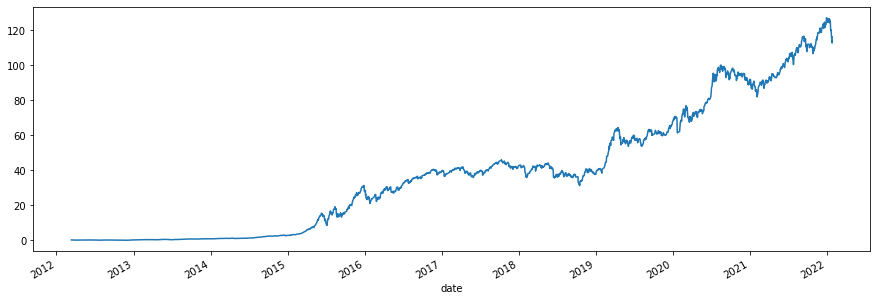

In [167]:
portfolio_ret12_22['alpha_head20_high_cum'].plot(figsize=(15,5))

<AxesSubplot:xlabel='date'>

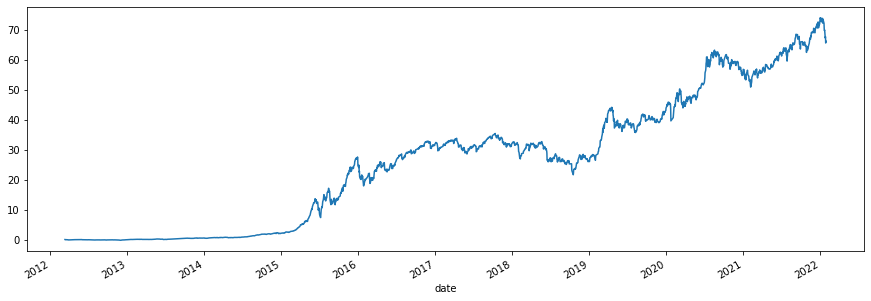

In [168]:
portfolio_ret12_22['alpha_head40_high_cum'].plot(figsize=(15,5))

<AxesSubplot:xlabel='date'>

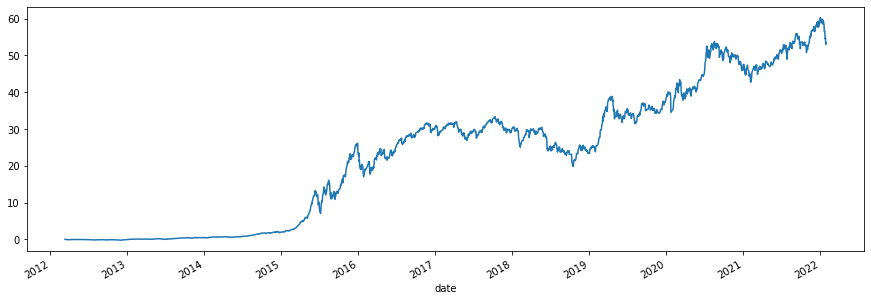

In [169]:
portfolio_ret12_22['alpha_head60_high_cum'].plot(figsize=(15,5))

<AxesSubplot:xlabel='date'>

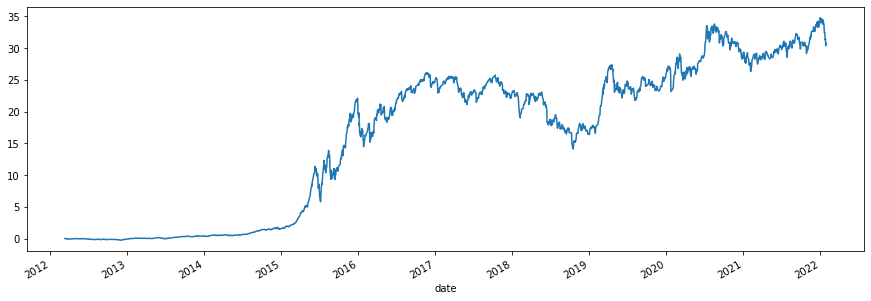

In [170]:
portfolio_ret12_22['alpha_head80_high_cum'].plot(figsize=(15,5))

<AxesSubplot:xlabel='date'>

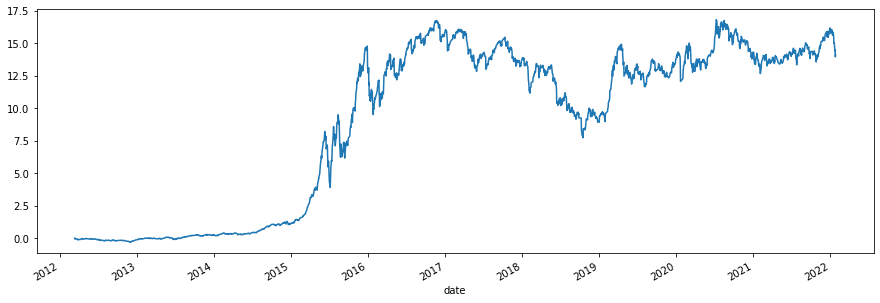

In [171]:
portfolio_ret12_22['alpha_head100_high_cum'].plot(figsize=(15,5))

##### **3.2、十等分多空组合：期货空头**

In [68]:
#分组收益单因子测试函数：高组合滚动收益
def portfolio_ret_hedge(sty,resid_n,start,end,cost):
    
    portfolio_ret = pd.concat([sty[['code','date','return']], resid_n], axis = 1)
    portfolio_ret = portfolio_ret.merge(Future_first, on = 'date', how = 'left')
    portfolio_ret.loc[:,'return_hedge'] = portfolio_ret['return'] - portfolio_ret['F_return']
    portfolio_ret.loc[:,'return_1'] = portfolio_ret.groupby('code')['return_hedge'].shift(-1)#求return的一阶前置项
    portfolio_ret.dropna(inplace=True)#删除空值行
    
    residlist = resid_n.columns
    groupR_all = pd.DataFrame()
    for resid in residlist:
        alphas_t = portfolio_ret[['code','date','return_1',resid]].copy()#选出需要的列
        alphas_t.loc[:,resid] = alphas_t.groupby(['date'])[resid].rank(method='first', pct=True)*10#排序
        alphas_t.loc[:,resid] = alphas_t[resid].astype(str).str.slice(0,1).astype(int)#组号
        alphas_t_groupR = alphas_t.groupby(['date',resid], as_index = False)['return_1'].mean()#每日收益均值
        alphas_t_groupR = alphas_t_groupR.pivot('date',resid,'return_1')#透视
        
        alphas_t_groupR = alphas_t_groupR.loc[start:end,[9]]
        alphas_t_groupR[resid+'_high_cum'] = (alphas_t_groupR[[9]]+1-cost).cumprod() -1 #高组合滚动投资收益
        
        groupR_all = pd.concat([groupR_all,alphas_t_groupR], axis = 1)#合并
    
    return groupR_all

In [69]:
portfolio_ret_hedge12_22 = portfolio_ret_hedge(style,resid_comb,start = '2012-03-12',end = '2022-01-27',cost = 0.001)

In [70]:
portfolio_ret_hedge17_22 = portfolio_ret_hedge(style,resid_comb,start = '2017-01-01',end = '2022-01-27',cost = 0.001)

In [130]:
portfolio_ret_hedge12_22

,9,alpha_head20_high_cum,9,alpha_head40_high_cum,9,alpha_head60_high_cum,9,alpha_head80_high_cum,9,alpha_head100_high_cum,9,alpha_head120_high_cum
date,,,,,,,,,,,,
2012-03-12,0.002399,0.001399,0.002938,0.001938,0.003403,0.002403,0.004971,0.003971,0.005208,0.004208,0.005757,0.004757
2012-03-13,-0.023285,-0.022919,-0.023753,-0.022863,-0.024150,-0.022807,-0.021801,-0.018920,-0.019401,-0.016279,-0.019891,-0.016233
2012-03-14,-0.004137,-0.027939,-0.007320,-0.030993,-0.009125,-0.032701,-0.011023,-0.030716,-0.012756,-0.029811,-0.015526,-0.032491
2012-03-15,0.025800,-0.003832,0.023952,-0.008752,0.024397,-0.010069,0.023928,-0.008492,0.021969,-0.009467,0.023284,-0.010931
2012-03-16,0.014922,0.010037,0.013585,0.003723,0.015198,0.003987,0.014940,0.005329,0.012729,0.002151,0.014238,0.002163
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,0.003892,39.968852,0.003824,22.864461,0.003699,18.541912,0.004039,10.366621,0.004092,4.435613,0.005334,1.033766
2022-01-24,-0.019083,39.146063,-0.018002,22.410990,-0.017732,18.175848,-0.017509,10.156232,-0.018985,4.326983,-0.019924,0.991211
2022-01-25,0.005204,39.314851,0.004926,22.502891,0.003821,18.229945,0.003619,10.185454,0.002777,4.336450,0.003177,0.995546


In [128]:
portfolio_ret_hedge17_22

,9,alpha_head20_high_cum,9,alpha_head40_high_cum,9,alpha_head60_high_cum,9,alpha_head80_high_cum,9,alpha_head100_high_cum,9,alpha_head120_high_cum
date,,,,,,,,,,,,
2017-01-03,0.006802,0.005802,0.006344,0.005344,0.006652,0.005652,0.007800,0.006800,0.008400,0.007400,0.010170,0.009170
2017-01-04,0.004725,0.009549,0.004360,0.008721,0.003227,0.007891,0.004555,0.010379,0.004619,0.011046,0.004154,0.012352
2017-01-05,-0.003200,0.005309,-0.003170,0.004515,-0.004044,0.002808,-0.003922,0.005406,-0.004360,0.005626,-0.005681,0.005589
2017-01-06,-0.001552,0.002743,-0.001650,0.001853,-0.000759,0.001044,-0.001217,0.003177,-0.000361,0.004258,-0.001395,0.003181
2017-01-09,0.002077,0.003823,0.001244,0.002098,0.001431,0.001475,0.000754,0.002930,0.000948,0.004205,0.000553,0.002732
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,0.003892,0.704303,0.003824,0.216614,0.003699,0.035669,0.004039,-0.266374,0.004092,-0.457658,0.005334,-0.641508
2022-01-24,-0.019083,0.670075,-0.018002,0.193496,-0.017732,0.016269,-0.017509,-0.279953,-0.018985,-0.468497,-0.019924,-0.649009
2022-01-25,0.005204,0.677096,0.004926,0.198181,0.003821,0.019136,0.003619,-0.278067,0.002777,-0.467552,0.003177,-0.648245


12-22年组合收益

<AxesSubplot:xlabel='date'>

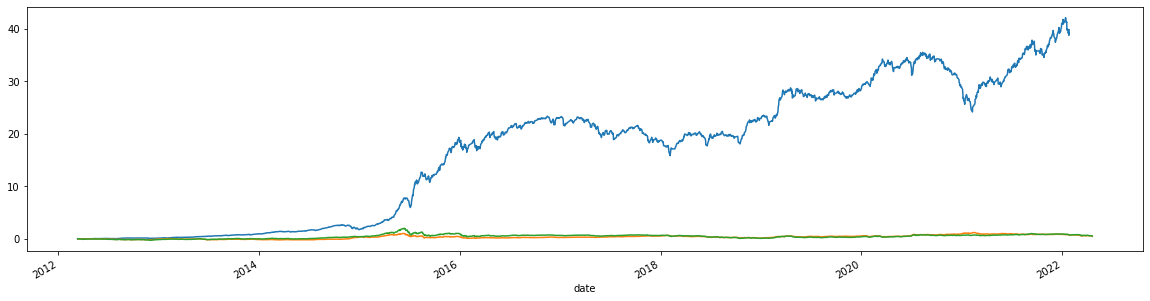

In [131]:
portfolio_ret_hedge12_22.loc[:,'alpha_head20_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc[:,'Index_ret_cum'].plot()
IDX_Idxtrd500.loc[:,'Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

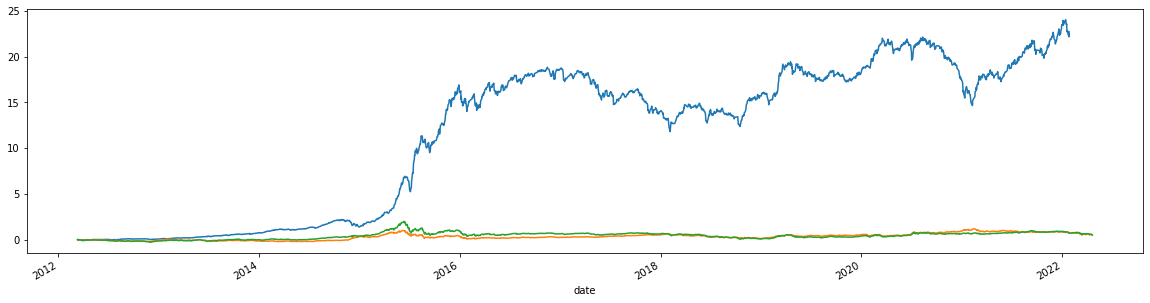

In [132]:
portfolio_ret_hedge12_22.loc[:,'alpha_head40_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc[:,'Index_ret_cum'].plot()
IDX_Idxtrd500.loc[:,'Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

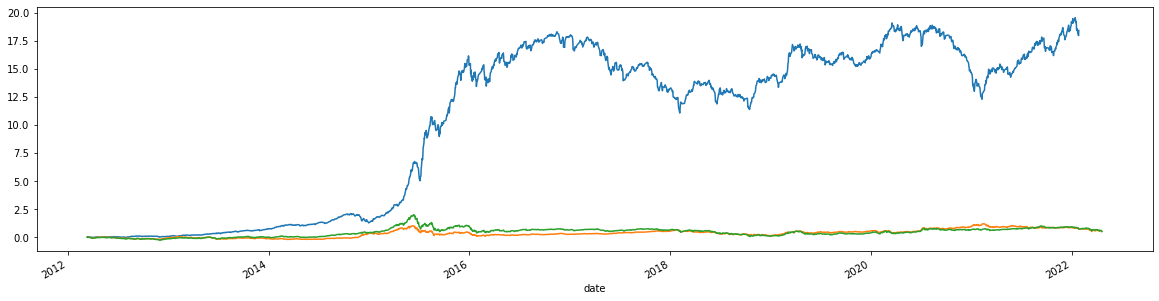

In [133]:
portfolio_ret_hedge12_22.loc[:,'alpha_head60_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc[:,'Index_ret_cum'].plot()
IDX_Idxtrd500.loc[:,'Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

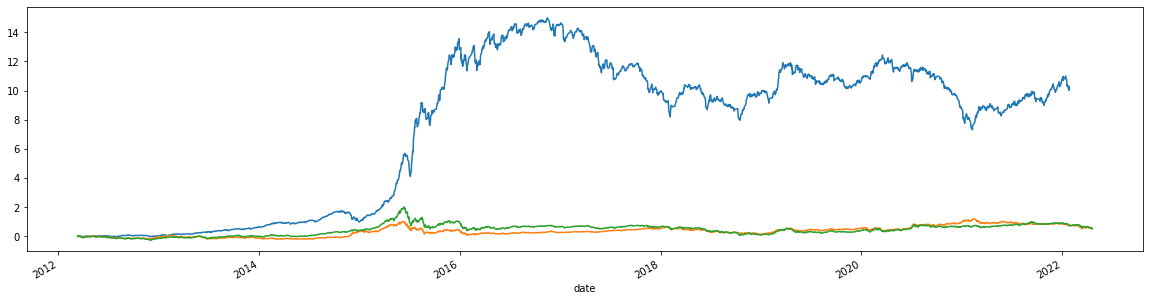

In [134]:
portfolio_ret_hedge12_22.loc[:,'alpha_head80_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc[:,'Index_ret_cum'].plot()
IDX_Idxtrd500.loc[:,'Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

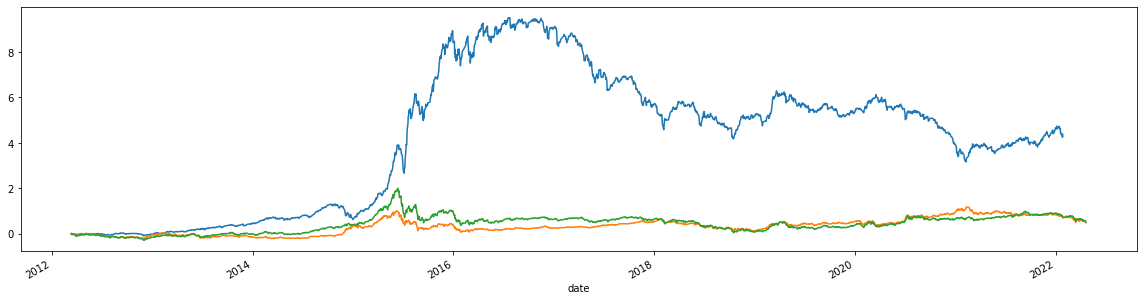

In [135]:
portfolio_ret_hedge12_22.loc[:,'alpha_head100_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc[:,'Index_ret_cum'].plot()
IDX_Idxtrd500.loc[:,'Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

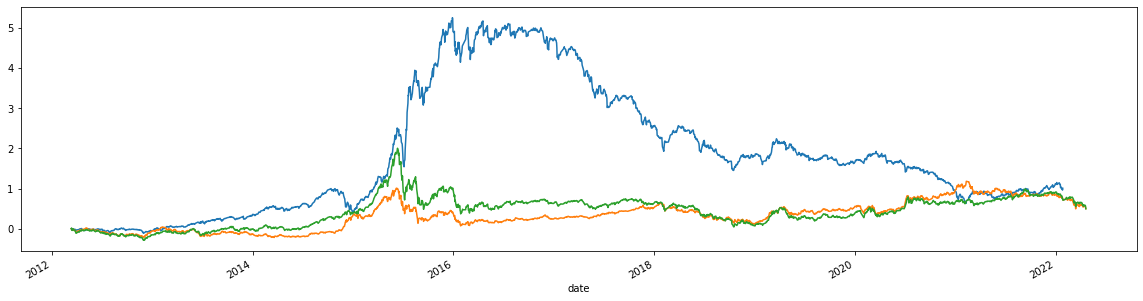

In [136]:
portfolio_ret_hedge12_22.loc[:,'alpha_head120_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc[:,'Index_ret_cum'].plot()
IDX_Idxtrd500.loc[:,'Index_ret_cum'].plot()

12-16年组合收益

<AxesSubplot:xlabel='date'>

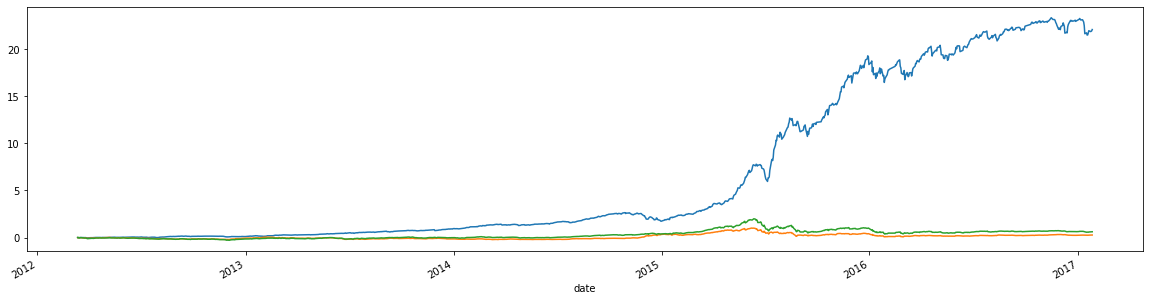

In [137]:
portfolio_ret_hedge12_22.loc['2012-03-12':'2017-01-27','alpha_head20_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()
IDX_Idxtrd500.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

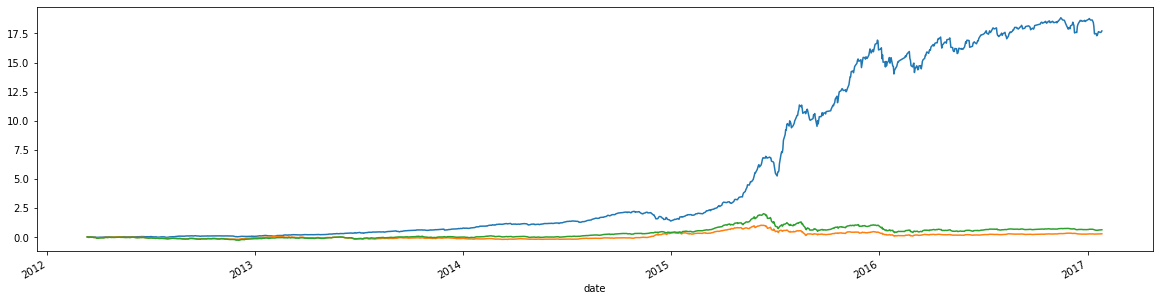

In [138]:
portfolio_ret_hedge12_22.loc['2012-03-12':'2017-01-27','alpha_head40_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()
IDX_Idxtrd500.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

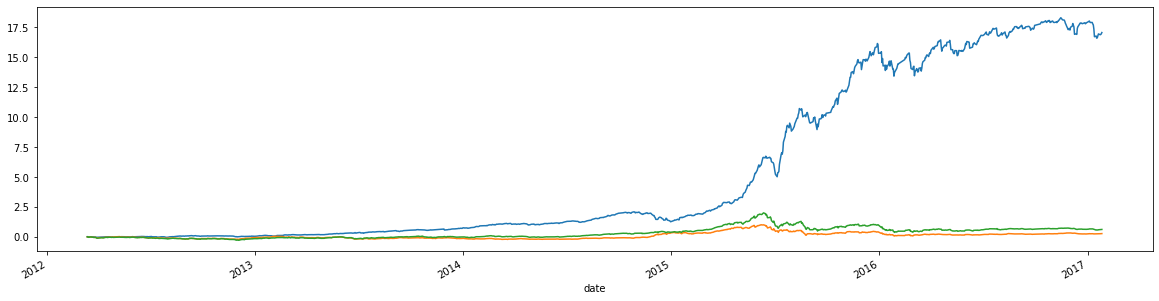

In [139]:
portfolio_ret_hedge12_22.loc['2012-03-12':'2017-01-27','alpha_head60_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()
IDX_Idxtrd500.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

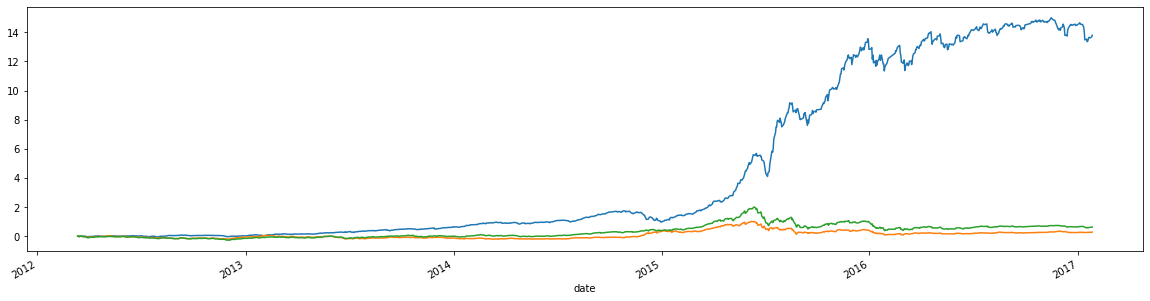

In [140]:
portfolio_ret_hedge12_22.loc['2012-03-12':'2017-01-27','alpha_head80_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()
IDX_Idxtrd500.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

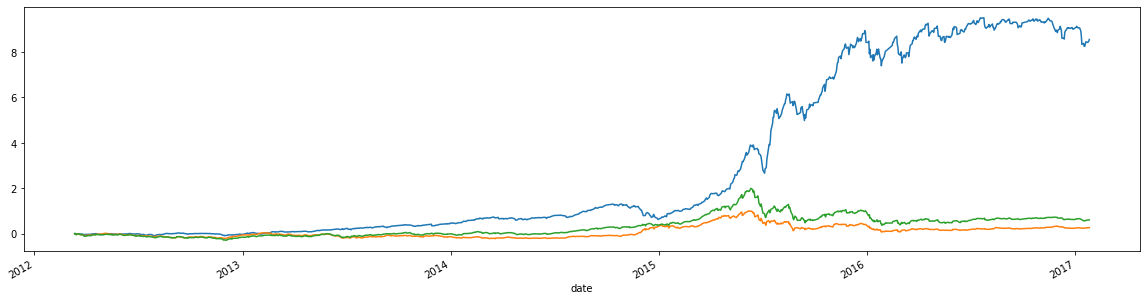

In [141]:
portfolio_ret_hedge12_22.loc['2012-03-12':'2017-01-27','alpha_head100_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()
IDX_Idxtrd500.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()

<AxesSubplot:xlabel='date'>

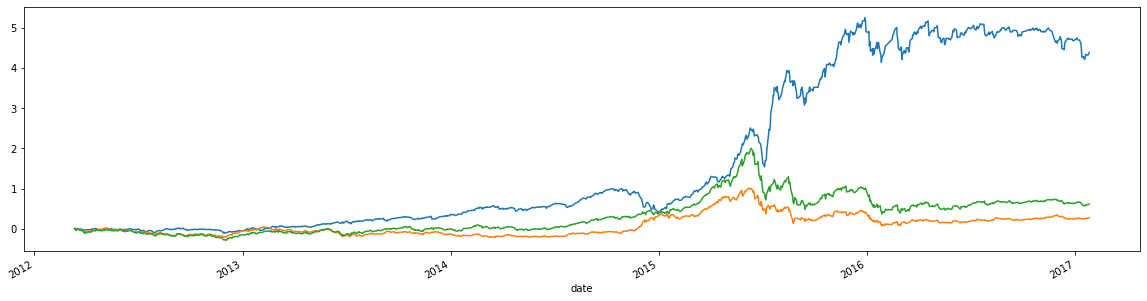

In [142]:
portfolio_ret_hedge12_22.loc['2012-03-12':'2017-01-27','alpha_head120_high_cum'].plot(figsize=(20,5))
IDX_Idxtrd300.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()
IDX_Idxtrd500.loc['2012-03-12':'2017-01-27','Index_ret_cum'].plot()

17-22年组合收益

<AxesSubplot:xlabel='date'>

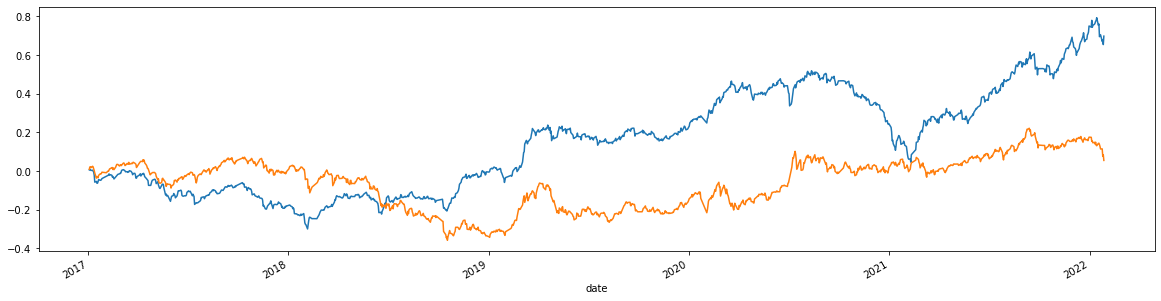

In [173]:
portfolio_ret_hedge17_22.loc[:,'alpha_head20_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

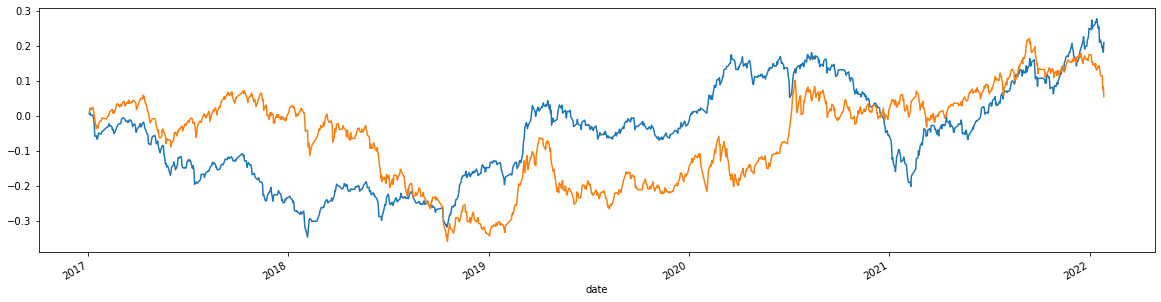

In [174]:
portfolio_ret_hedge17_22.loc[:,'alpha_head40_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

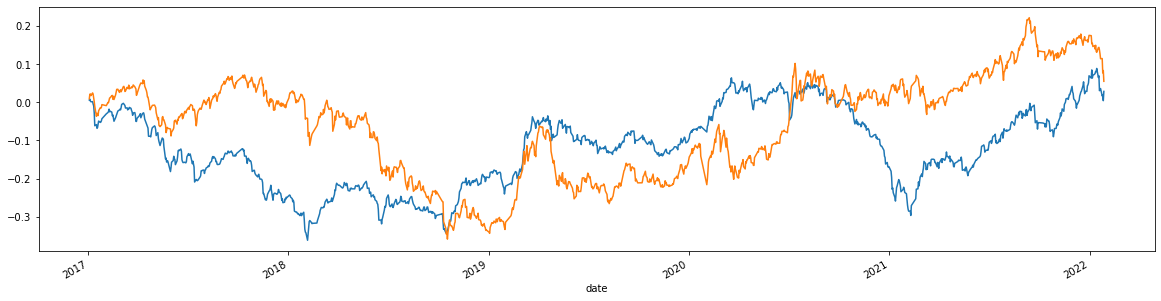

In [175]:
portfolio_ret_hedge17_22.loc[:,'alpha_head60_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

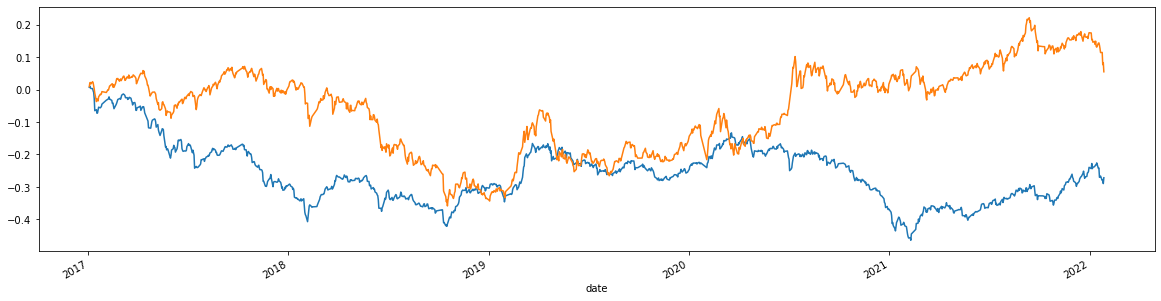

In [176]:
portfolio_ret_hedge17_22.loc[:,'alpha_head80_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

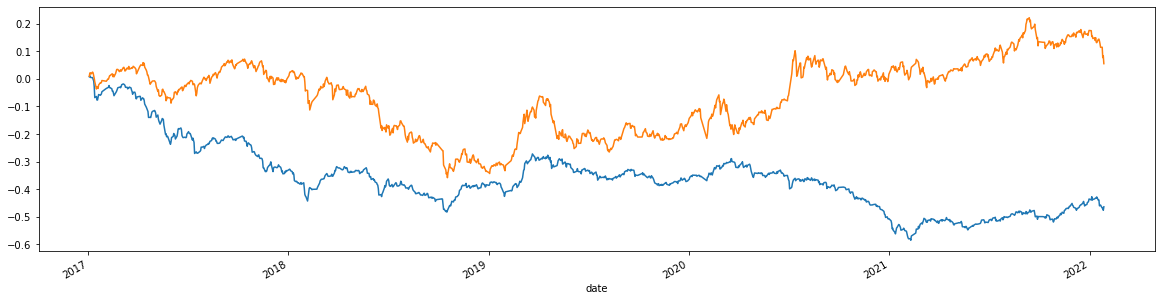

In [177]:
portfolio_ret_hedge17_22.loc[:,'alpha_head100_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

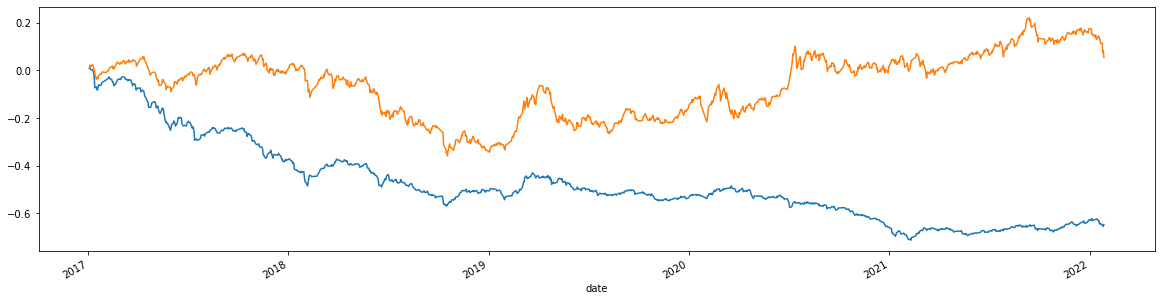

In [71]:
portfolio_ret_hedge17_22.loc[:,'alpha_head120_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

##### **3.3、前120只股票多空组合：期货空头**

In [40]:
#分组收益单因子测试函数：高组合滚动收益
def portfolio_ret_hedgenum(sty,resid_n,start,end,cost,stk_num):
    
    portfolio_ret = pd.concat([sty[['code','date','return']], resid_n], axis = 1)
    portfolio_ret = portfolio_ret.merge(Future_first, on = 'date', how = 'left')
    portfolio_ret.loc[:,'return_hedge'] = portfolio_ret['return'] - portfolio_ret['F_return']
    portfolio_ret.loc[:,'return_1'] = portfolio_ret.groupby('code')['return_hedge'].shift(-1)#求return的一阶前置项
    portfolio_ret.dropna(inplace=True)#删除空值行
    
    residlist = resid_n.columns
    groupR_all = pd.DataFrame()
    for resid in residlist:
        alphas_t = portfolio_ret[['code','date','return_1',resid]].copy()#选出需要的列
        alphas_t.loc[:,resid] = alphas_t.groupby(['date'])[resid].rank(method='first', ascending=False)#排序
        alphas_t= alphas_t[alphas_t[resid] <= stk_num]#每日选因子值排名前120的股票
        alphas_t_groupR = alphas_t.groupby(['date'], as_index = False)['return_1'].mean()#每日收益均值
        alphas_t_groupR.set_index('date',inplace=True)
        alphas_t_groupR = alphas_t_groupR.loc[start:end,:]#区间截取
        
        alphas_t_groupR[resid+'_high_cum'] = (alphas_t_groupR['return_1']+1-cost).cumprod() -1
        groupR_all = pd.concat([groupR_all,alphas_t_groupR], axis = 1)#合并
    
    return groupR_all

In [78]:
portfolio_ret_hedge120_12_22 = portfolio_ret_hedgenum(style,resid_comb,start='2012-03-12',end='2022-01-27',cost=0.001,stk_num=120)

In [53]:
portfolio_ret_hedge120_17_22 = portfolio_ret_hedgenum(style,resid_comb,start='2017-01-01',end='2022-01-27',cost=0.001,stk_num=120)

In [54]:
portfolio_ret_hedge50_12_22 = portfolio_ret_hedgenum(style,resid_comb,start='2012-03-12',end='2022-01-27',cost=0.001,stk_num=50)

In [91]:
portfolio_ret_hedge50_17_22 = portfolio_ret_hedgenum(style,resid_comb,start='2017-01-01',end='2022-01-27',cost=0.0015,stk_num=50)

In [92]:
portfolio_ret_hedge50_17_22

,return_1,alpha_head20_high_cum,return_1,alpha_head40_high_cum,return_1,alpha_head60_high_cum,return_1,alpha_head80_high_cum,return_1,alpha_head100_high_cum,return_1,alpha_head120_high_cum
date,,,,,,,,,,,,
2017-01-03,0.006223,0.004723,0.010369,0.008869,0.009139,0.007639,0.012267,0.010767,0.018487,0.016987,0.019426,0.017926
2017-01-04,0.002833,0.006062,0.009700,0.017141,0.008057,0.014246,0.007470,0.016801,0.007445,0.023032,0.006315,0.022828
2017-01-05,-0.004997,-0.000474,-0.002837,0.012730,-0.000173,0.012549,-0.003033,0.012192,-0.005248,0.016129,-0.007448,0.013675
2017-01-06,-0.000604,-0.002577,-0.003519,0.007647,-0.000981,0.010036,-0.003246,0.007389,-0.006066,0.008441,-0.005616,0.006462
2017-01-09,0.008386,0.004291,0.008375,0.014575,0.004116,0.012678,0.003386,0.009289,0.003352,0.010308,0.003226,0.008199
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,0.007524,7.791369,0.006219,8.546288,0.002917,1.690052,0.004940,-0.231067,0.001352,-0.634444,0.000373,-0.887722
2022-01-24,-0.021450,7.589609,-0.014166,8.396734,-0.018596,1.635992,-0.022919,-0.249843,-0.022657,-0.643275,-0.025460,-0.890749
2022-01-25,0.004264,7.613348,0.001677,8.398397,0.000307,1.632848,0.001067,-0.250168,-0.002430,-0.644677,-0.002660,-0.891204


<AxesSubplot:xlabel='date'>

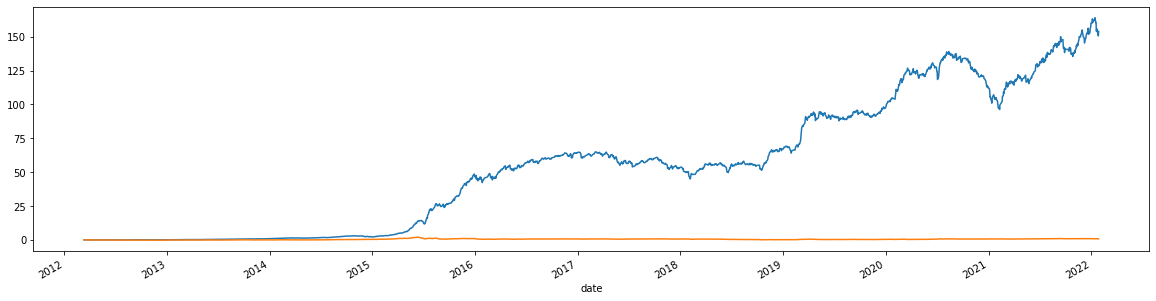

In [62]:
portfolio_ret_hedge120_12_22['alpha_head20_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2012-03-12':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

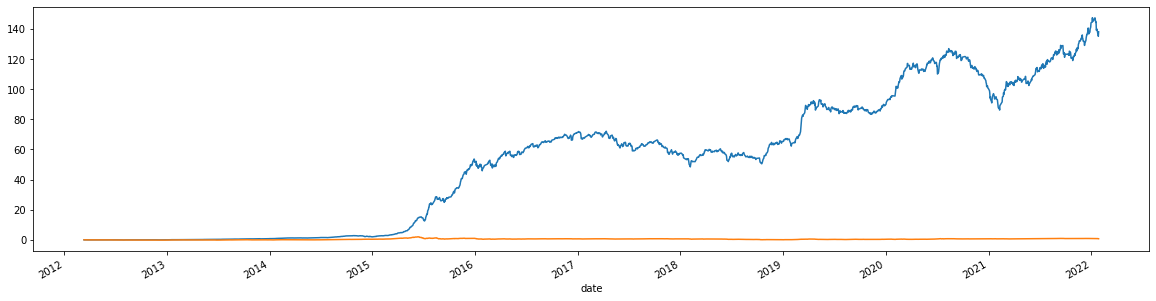

In [63]:
portfolio_ret_hedge120_12_22['alpha_head40_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2012-03-12':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

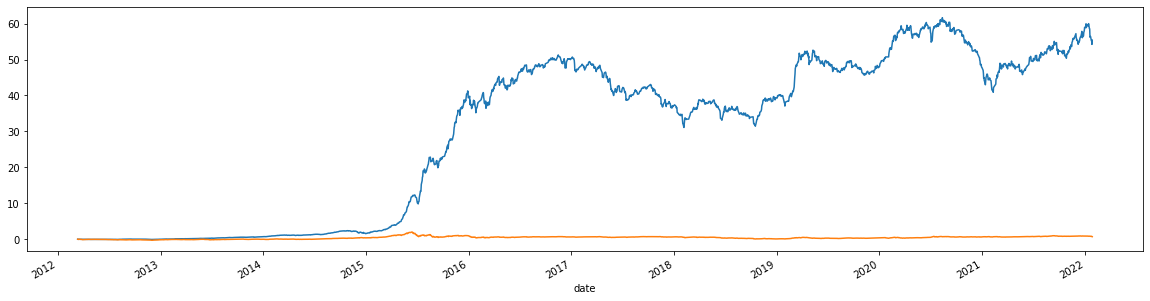

In [64]:
portfolio_ret_hedge120_12_22['alpha_head60_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2012-03-12':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

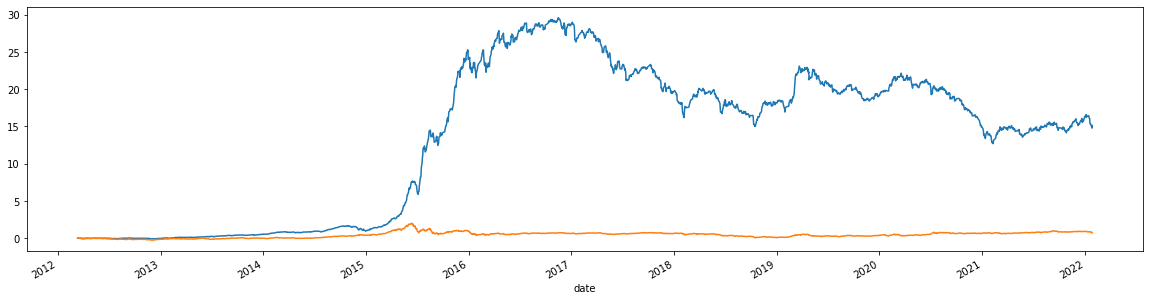

In [65]:
portfolio_ret_hedge120_12_22['alpha_head80_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2012-03-12':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

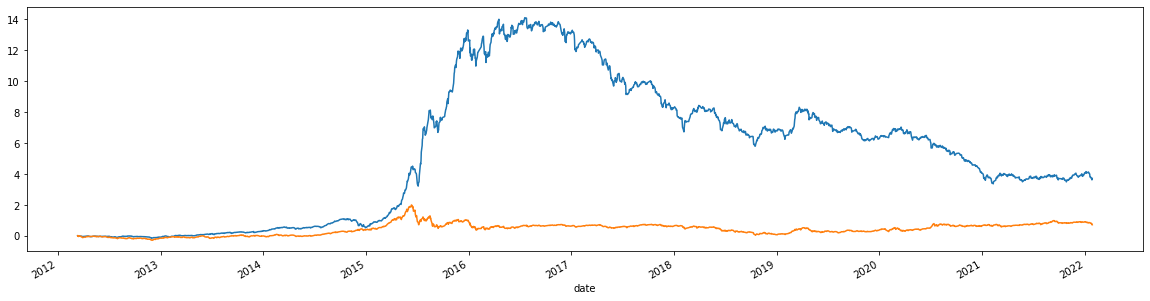

In [66]:
portfolio_ret_hedge120_12_22['alpha_head100_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2012-03-12':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

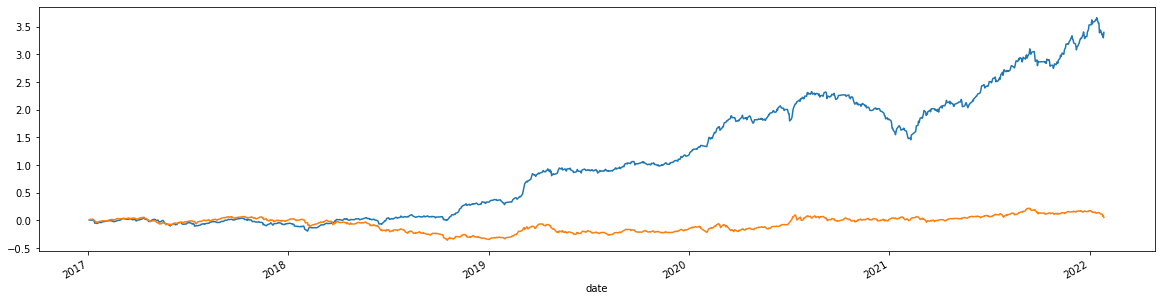

In [79]:
portfolio_ret_hedge120_17_22['alpha_head20_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

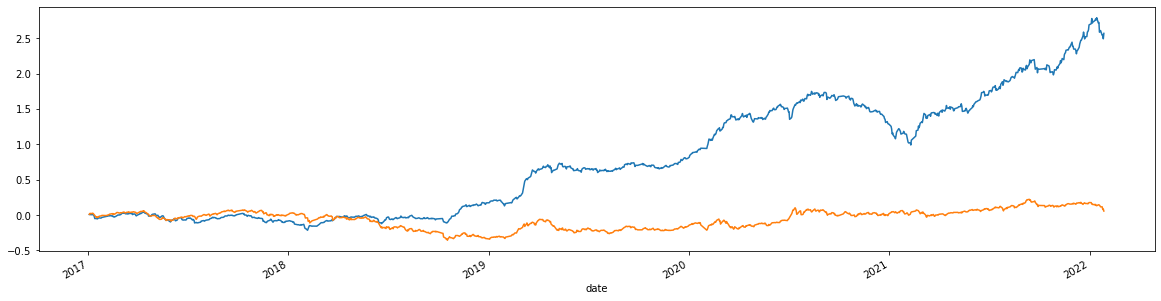

In [80]:
portfolio_ret_hedge120_17_22['alpha_head40_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

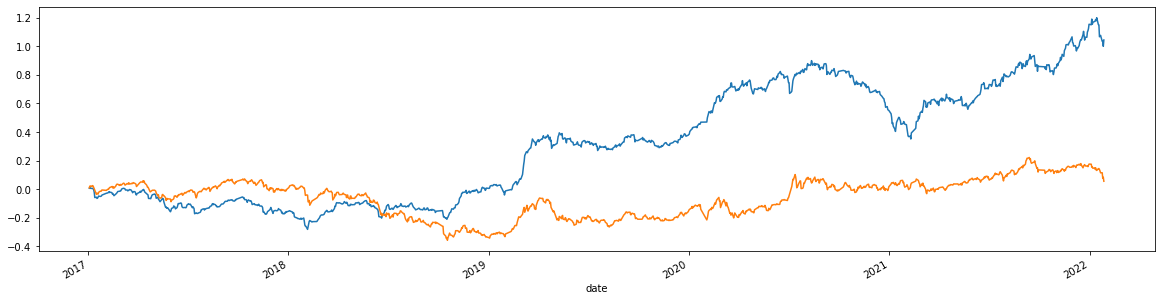

In [81]:
portfolio_ret_hedge120_17_22['alpha_head60_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

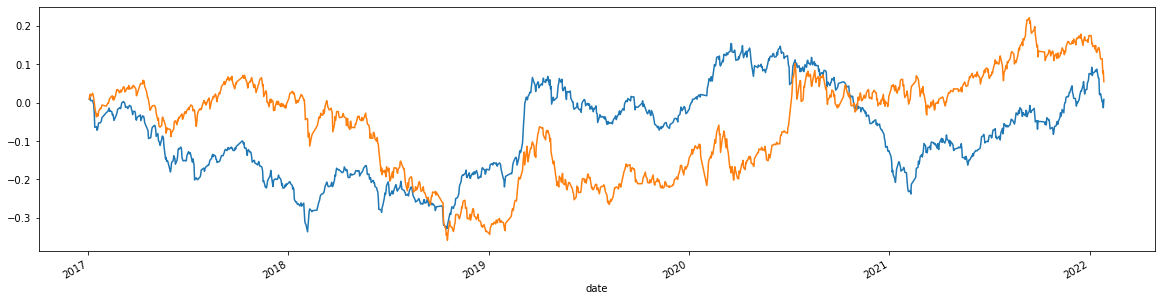

In [82]:
portfolio_ret_hedge120_17_22['alpha_head80_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

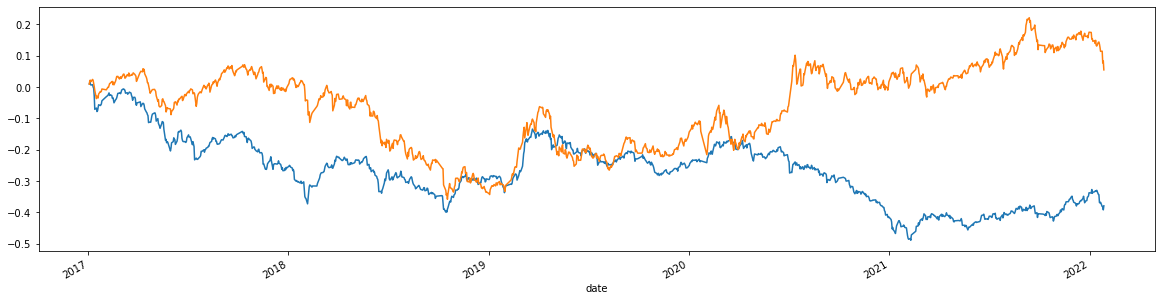

In [83]:
portfolio_ret_hedge120_17_22['alpha_head100_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

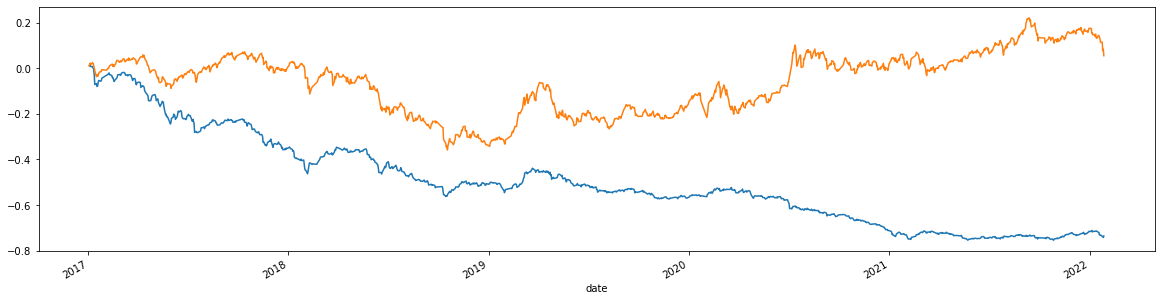

In [84]:
portfolio_ret_hedge120_17_22['alpha_head120_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

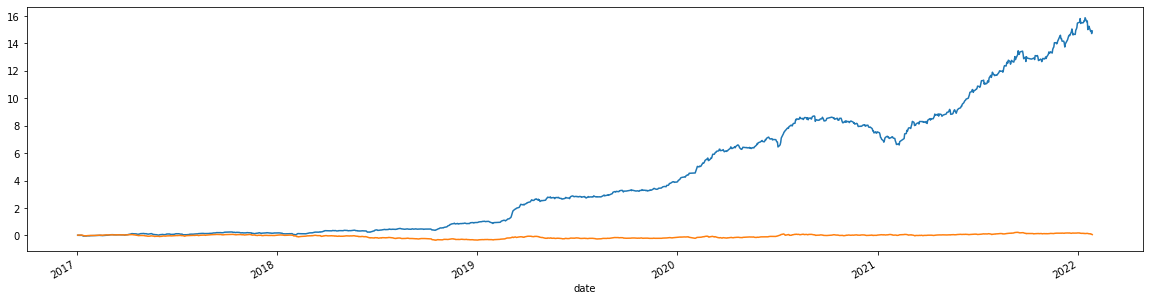

In [87]:
portfolio_ret_hedge50_17_22['alpha_head20_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

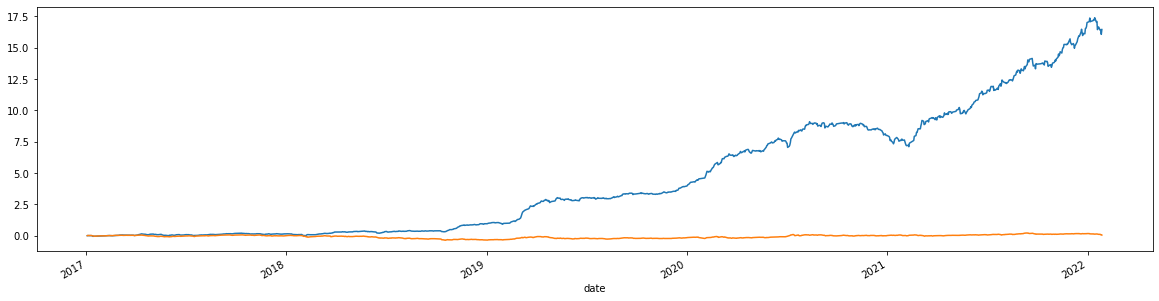

In [88]:
portfolio_ret_hedge50_17_22['alpha_head40_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

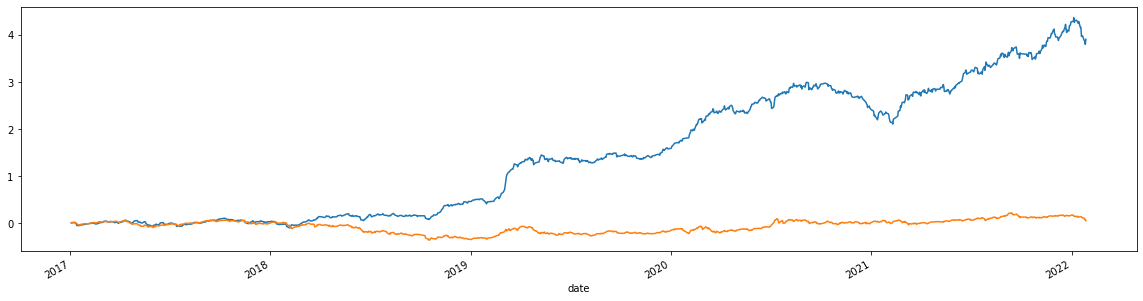

In [90]:
portfolio_ret_hedge50_17_22['alpha_head60_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

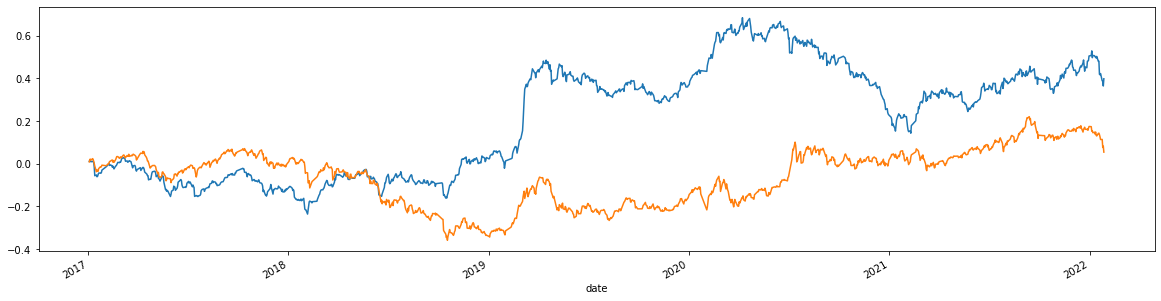

In [73]:
portfolio_ret_hedge50_17_22['alpha_head80_high_cum'].plot(figsize=(20,5))
((IDX_Idxtrd500.loc['2017-01-01':'2022-01-27','Index_ret']+1).cumprod()-1).plot(figsize=(20,5))